# Cluster analysis of seasonal and diurnal precipitation

## General info about K means algorithm

- input: K (nr of clusters) and data in form of 2D array)
- calculate Euclidean distance to centroids of data  
- updating centroid by calculating means of all data points which are assigned to one specific centroid's cluster

## Notes 

- GPM data: seasonal= 'GPM_IMERG_cluster_input_seasonal.nc4' , diurnal: 'GPM_IMERG_cluster_input_diurnal.nc4'
- best nr of classes for seasonal seems to be 8 
- two distinct classes when seasonality is separated ! see figures 
- always 2D input maxtrix: n x features (monthly contribution to annual precip, hourly contribution to daily precip)
- cluster analysis meaningful? Are there real clusters or just continuous differences? Maybe PCA is more suitable.. 
- plot PCA1 and PCA2 for grid (how much can a certain occurrence of seasonality explain the variance in the data? ), here there could be two modes in different combinations and intensities 
- one output is are the features for each component (seasonal curve for PCA1, seasonal curve for PCA2.....etc) 
- another output are the eigenvalues for each grid cell (data point) for each component: the larger the eigenvalue for that component, the more that component explains the data point or: how strong a number shows how dominant a the seasonality feature in a specific region is 
- include only for daily values from 0.1 mm/hr in order to derive the diurnal vectors 

## Comparison PCA and cluster analysis 

- show the same results, inversed seasonality for Karakoram and northwest out of TP (rather sharp border along the western mountain ranges)
- PCA 2 shows dipole pattern within TP, PCA1 outside 

In [88]:
from sklearn import cluster
#import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans


import os
import glob 
import random 

import matplotlib.pyplot as plt
import cartopy
from mpl_toolkits.basemap import *
import mpl_toolkits
#import Basemap
import matplotlib.colors as colors

import scipy
from scipy import ndimage
from scipy.stats import skew
from scipy.ndimage import label, generate_binary_structure
import matplotlib.pyplot as plt

from netCDF4 import Dataset
from collections import Counter 

from numpy import genfromtxt

import pandas as pd 


In [89]:
# read in dataset on which the cluster analysis will be performed 
def read_in_netcdf(file):
    dataset = Dataset(file)    
    precip= np.array(dataset["precipitationCal"])
    lon= np.array(dataset["lon"])
    lat= np.array(dataset["lat"])
    dataset.close()
    return precip, lon, lat


In [90]:
file = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/GPM_IMERG_cluster_input_seasonal.nc4'
precip, lon, lat = read_in_netcdf(file)

In [4]:
#convert 3D matrix to 2D input matrix with n_gridpoints x n_features
data= np.reshape(precip, (12,351*181))
data= data.transpose()
np.shape(data)

(63531, 12)

In [21]:
X = data # input matrix shape (n_samples, n_features)
k = 7
kmeans = KMeans(n_clusters= k, random_state=0).fit(X)

# attributes
centers = kmeans.cluster_centers_ # n_clusters x n_features
labels = kmeans.labels_ # contains the actual classes 
cluster_grid= np.reshape(kmeans.labels_, ((351,181)))


np.shape(kmeans.cluster_centers_)
#np.shape(kmeans.labels_)

(7, 12)

## Plots

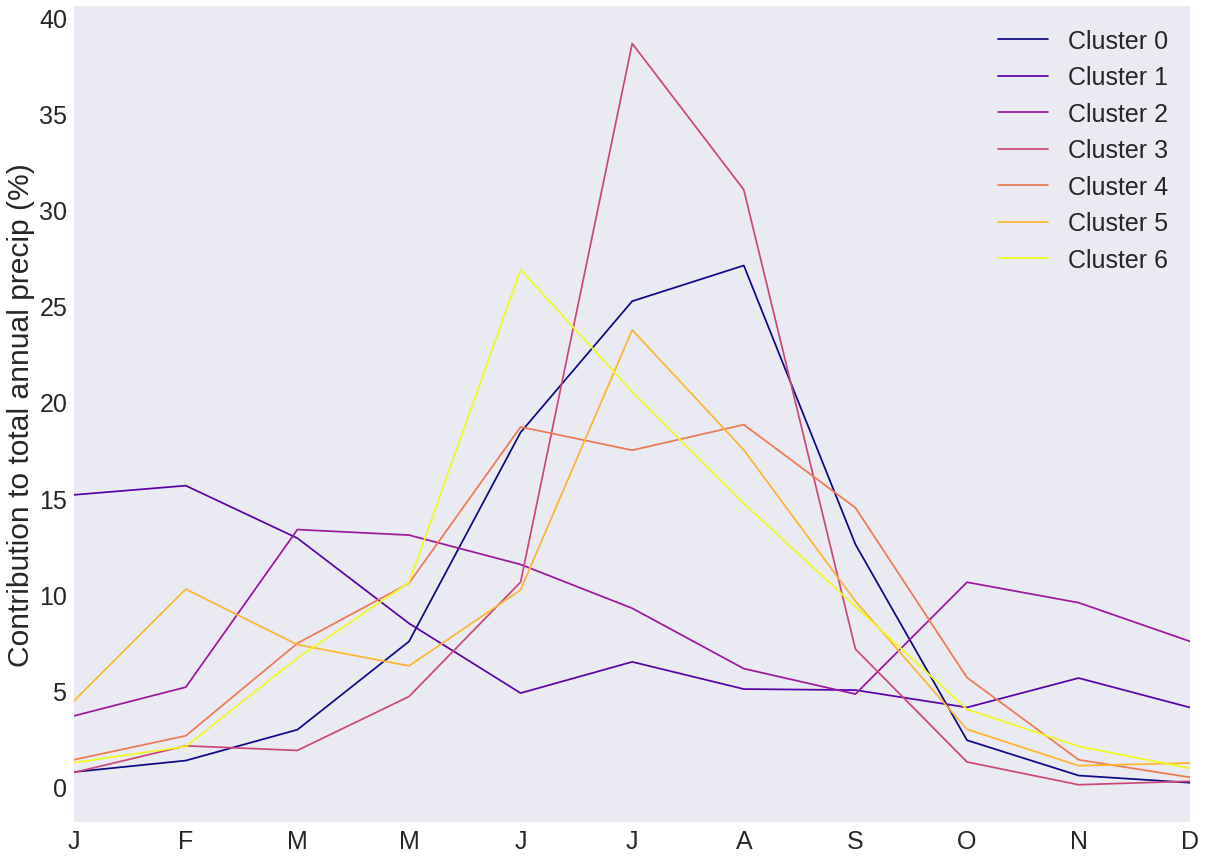

In [22]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})
plt.figure(figsize=(20, 15))
plt.ylabel('Contribution to total annual precip (%)', fontsize= 30)
labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(1,12,1), labels)
plt.grid()
plt.xlim(1,11)


n = 7
colors = plt.cm.plasma(np.linspace(0,1,n))

for i in range(n):
    plt.plot(kmeans.cluster_centers_[i], label = 'Cluster '+ str(i) , color=colors[i])

         
         
plt.legend( prop={'size': 25})
#plt.show()
plt.rcParams.update({'font.size': 30})


plt.savefig('/media/juli/Elements/comparison/gpm_seasonal_cluster7.pdf')

In [77]:
# fast plot
#plt.imshow(cluster_grid)

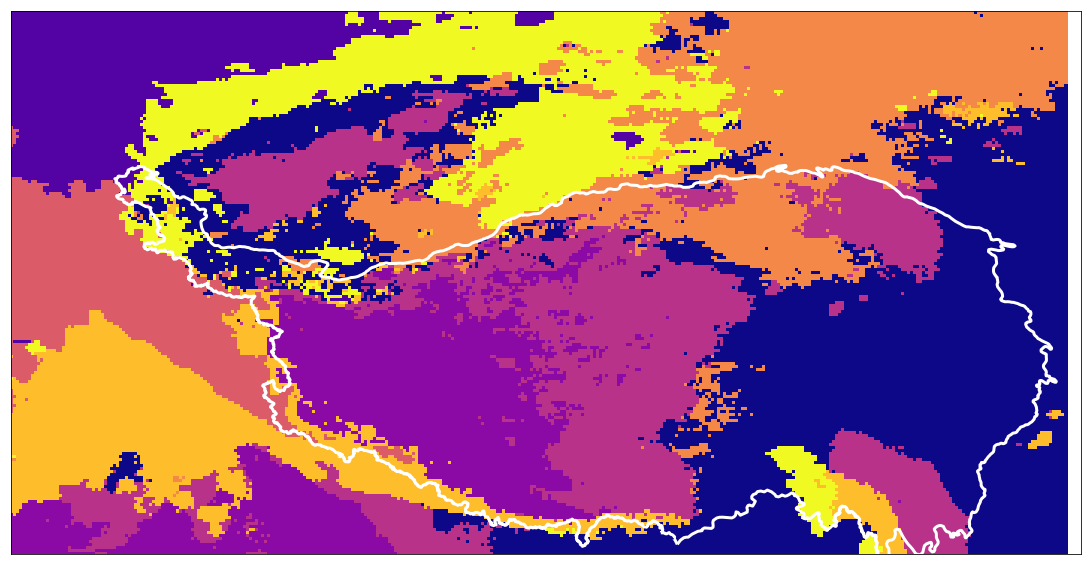

In [20]:
plt.figure(figsize=(20, 10))


cmap = plt.cm.get_cmap('plasma')
m = Basemap(projection='cyl', llcrnrlat=26.95, urcrnrlat= 44.95, llcrnrlon=70.05, urcrnrlon=105.5,  resolution = 'c')
lons, lats =np.meshgrid(lon, lat)
xi,yi = m(lons,lats)
cs = m.pcolormesh(xi,yi, cluster_grid.T, cmap = cmap) 


# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='white', linewidth=3.0)

plt.savefig('/media/juli/Elements/comparison/cluster_seasonal_grid7_new.png')

- cluster analysis of seasonality indicate that pixels are more similar along west-east axis compared to north- south axis (different to Yao et al framework)
- two clusters are found which have opposite curve (with peaks in spring in autumn and summer depression), but these are outside of the plateau (from westerly direction)  

## check 

In [141]:
file = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/GPM_IMERG_20170628_contr_to_day.nc4'
check, lon, lat = read_in_netcdf(file)


## Cluster analysis diurnal 

In [7]:
file = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/gpm_imerg_cluster_input_diurnal.nc4'
precip, lon, lat = read_in_netcdf(file)

In [9]:
# calculate hourly instead of 30 min 
precip_avg= np.zeros((351,181))
i=0 
for idx, row in enumerate(precip[:,:]):
    if (i % 2) == 0:
        a = np.nanmean([row, precip[:,:][idx]], axis = 0)
        #print(idx, np.shape(a))
        precip_avg= np.concatenate((precip_avg, a),axis =0)
    i+=1
print(np.shape(precip_avg))

In [11]:
new = np.reshape(precip_avg,(25,351,181))
precip = new[1::,:,:]
np.shape(precip)

(24, 351, 181)

In [13]:
#convert 3D matrix to 2D input matrix with n_gridpoints x n_features
data= np.reshape(precip, (24,351*181))
data= data.transpose()

In [14]:
X = data # input matrix shape (n_samples, n_features)
k = 5
kmeans = KMeans(n_clusters= k, random_state=0).fit(X)

# attributes
centers = kmeans.cluster_centers_ # n_clusters x n_features
labels = kmeans.labels_ # contains the actual classes 
cluster_grid= np.reshape(kmeans.labels_, ((351,181)))


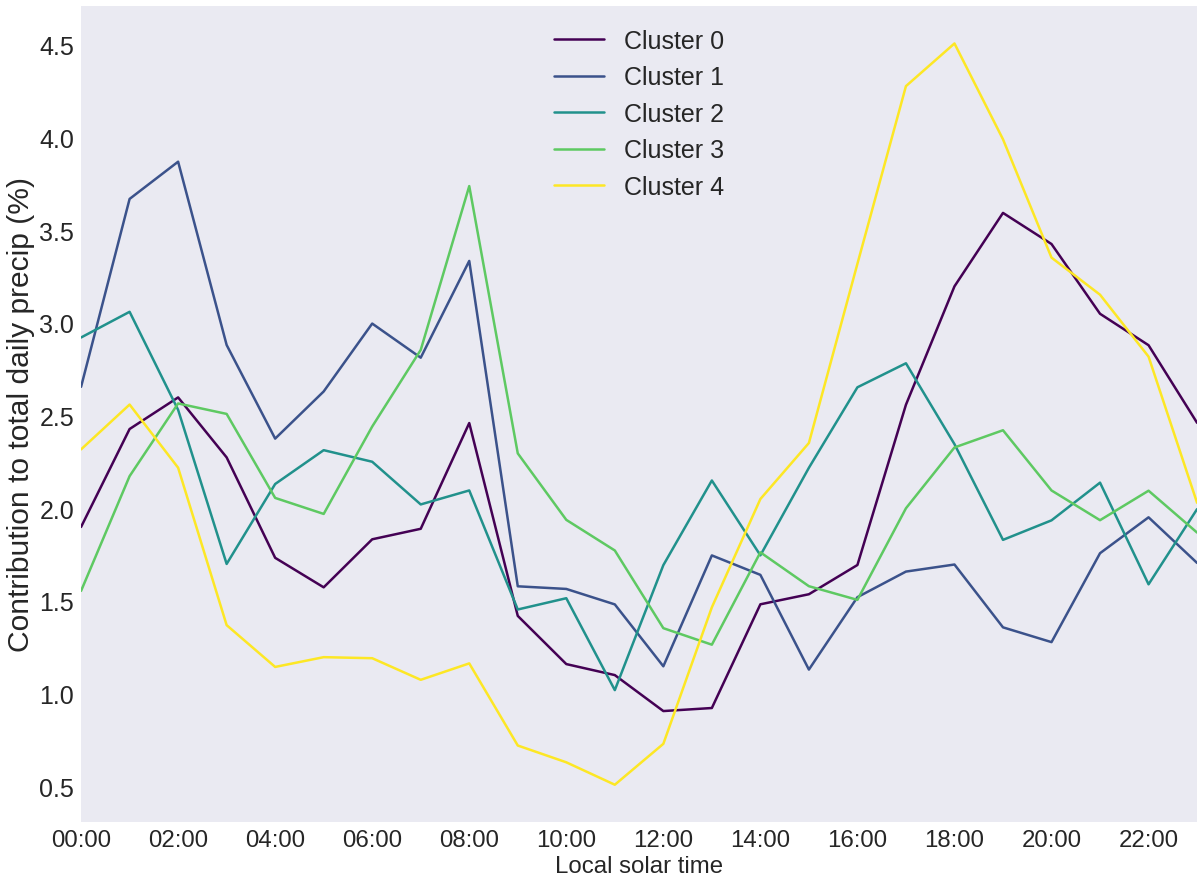

In [121]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})
plt.figure(figsize=(20, 15))
plt.ylabel('Contribution to total daily precip (%)', fontsize= 30)
plt.grid()

n = 5
colors = plt.cm.viridis(np.linspace(0,1,n))

for i in range(n):
    localtime=np.array(())
    localtime=np.append(localtime, centers[i, 16:24])
    localtime=np.append(localtime, centers[i, 0:16])
    plt.plot(localtime, label = 'Cluster '+ str(i) , color=colors[i], linewidth= 2.5)

plt.xlim(0,23)
plt.xlabel('Local solar time', fontsize= 24 )
labels=['00:00','02:00','04:00','06:00','08:00','10:00','12:00','14:00','16:00','18:00','20:00','22:00']
plt.xticks(np.linspace(0,22,12), labels,  fontsize=24)
         

plt.legend( prop={'size': 25})
#plt.show()
plt.rcParams.update({'font.size': 30})

plt.savefig('/media/juli/Elements/comparison/gpm_diurnal_cluster5.pdf')

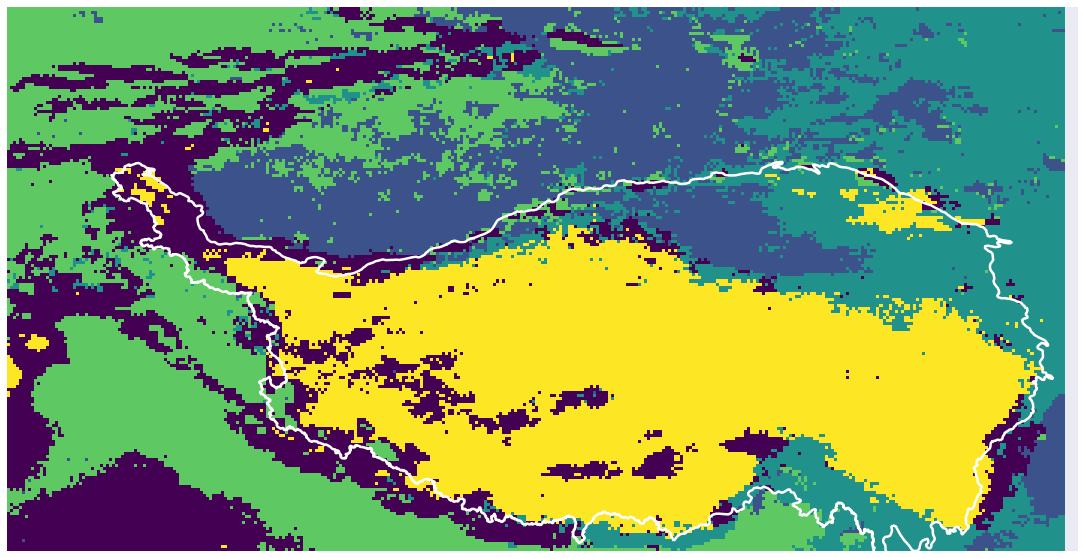

In [52]:
plt.figure(figsize=(20, 10))
cmap = plt.cm.get_cmap('viridis')
m = Basemap(projection='cyl', llcrnrlat=26.95, urcrnrlat= 44.95, llcrnrlon=70.05, urcrnrlon=105.5,  resolution = 'c')
lons, lats =np.meshgrid(lon, lat)
xi,yi = m(lons,lats)
cs = m.pcolormesh(xi,yi, cluster_grid.T, cmap = cmap) 


# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='white', linewidth=2.5)

plt.savefig('/media/juli/Elements/comparison/cluster_diurnal_grid5.png')

## Getting optimal k (number of clusters) with elbow method

- mean distance of all data points to their centroid as a function of k 
- this will always decrease, but find elbow point

## Nr. of clusters for season

In [175]:
dis = np.array(())

for l in np.unique(labels):
    selected_rows = data[labels == l,:]
    for col in np.arange(0,12):
        m = np.absolute(np.subtract(selected_rows[:,col],centers[l,col]))
        dis = np.append(dis,m, axis = 0)

In [176]:
mean_distance = np.nanmean(dis)
mean_distance

2.3438313514551603

In [198]:
# test different k
k_variations = [1, 2,3,4,5,6,7,8,9,10, 11, 12, 13, 14, 15, 16, 17]
distances = [] 

for k in k_variations:
    print('calculating... mean distances to centroid for K = ', k)
    kmeans = KMeans(n_clusters= k, random_state=0).fit(X)
    centers = kmeans.cluster_centers_ 
    labels = kmeans.labels_
    dis = np.array(())

    for l in np.unique(labels):
        selected_rows = data[labels == l,:]
        for col in np.arange(0,12):
            m = np.absolute(np.subtract(selected_rows[:,col],centers[l,col]))
            dis = np.append(dis,m, axis = 0)
        mean = np.nanmean(dis)
    mean_distance = np.nanmean(mean)
    distances.append(mean_distance)

calculating... mean distances to centroid for K =  1
calculating... mean distances to centroid for K =  2
calculating... mean distances to centroid for K =  3
calculating... mean distances to centroid for K =  4
calculating... mean distances to centroid for K =  5
calculating... mean distances to centroid for K =  6
calculating... mean distances to centroid for K =  7
calculating... mean distances to centroid for K =  8
calculating... mean distances to centroid for K =  9
calculating... mean distances to centroid for K =  10
calculating... mean distances to centroid for K =  11
calculating... mean distances to centroid for K =  12
calculating... mean distances to centroid for K =  13
calculating... mean distances to centroid for K =  14
calculating... mean distances to centroid for K =  15
calculating... mean distances to centroid for K =  16
calculating... mean distances to centroid for K =  17


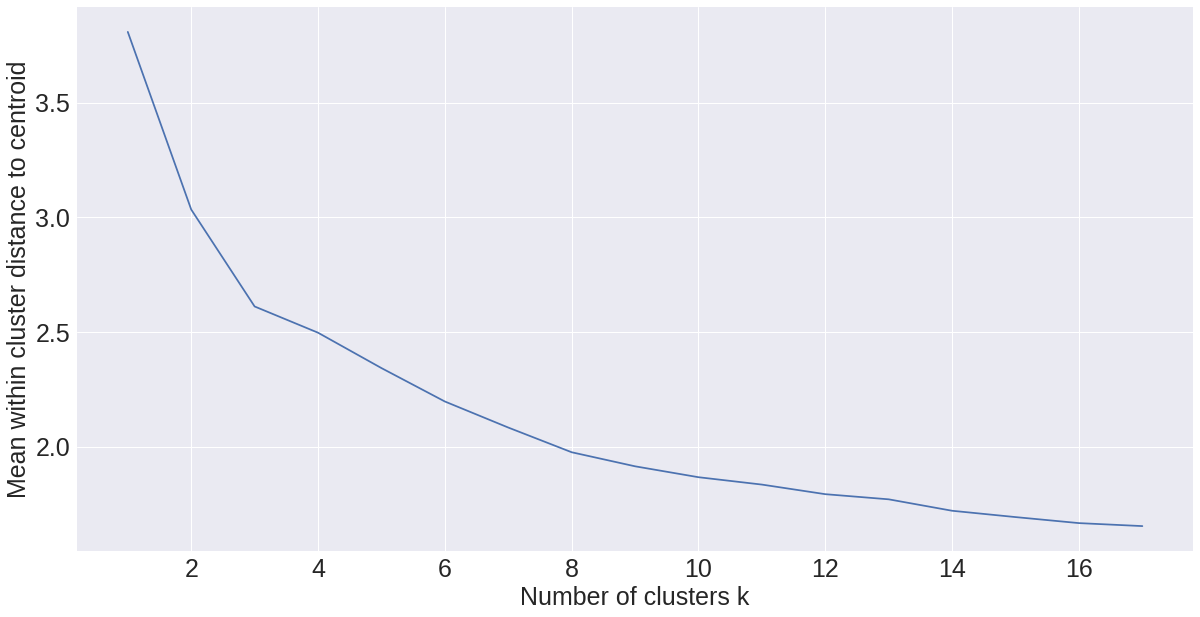

In [199]:
plt.figure(figsize=(20, 10))
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})

plt.plot(k_variations, distances)
plt.xlabel('Number of clusters k', fontsize = 25)
plt.ylabel('Mean within cluster distance to centroid', fontsize = 25)
plt.show()

## Nr. of clusters for diurnal curves

In [46]:
# test different k
k_variations = [1, 2,3,4,5,6,7,8,9,10, 11, 12, 13, 14, 15, 16, 17]
distances = [] 

for k in k_variations:
    print('calculating... mean distances to centroid for K = ', k)
    kmeans = KMeans(n_clusters= k, random_state=0).fit(X)
    centers = kmeans.cluster_centers_ 
    labels = kmeans.labels_
    dis = np.array(())

    for l in np.unique(labels):
        selected_rows = data[labels == l,:]
        for col in np.arange(0,12):
            m = np.absolute(np.subtract(selected_rows[:,col],centers[l,col]))
            dis = np.append(dis,m, axis = 0)
        mean = np.nanmean(dis)
    mean_distance = np.nanmean(mean)
    distances.append(mean_distance)

calculating... mean distances to centroid for K =  1
calculating... mean distances to centroid for K =  2
calculating... mean distances to centroid for K =  3
calculating... mean distances to centroid for K =  4
calculating... mean distances to centroid for K =  5
calculating... mean distances to centroid for K =  6
calculating... mean distances to centroid for K =  7
calculating... mean distances to centroid for K =  8
calculating... mean distances to centroid for K =  9
calculating... mean distances to centroid for K =  10
calculating... mean distances to centroid for K =  11
calculating... mean distances to centroid for K =  12
calculating... mean distances to centroid for K =  13
calculating... mean distances to centroid for K =  14
calculating... mean distances to centroid for K =  15
calculating... mean distances to centroid for K =  16
calculating... mean distances to centroid for K =  17


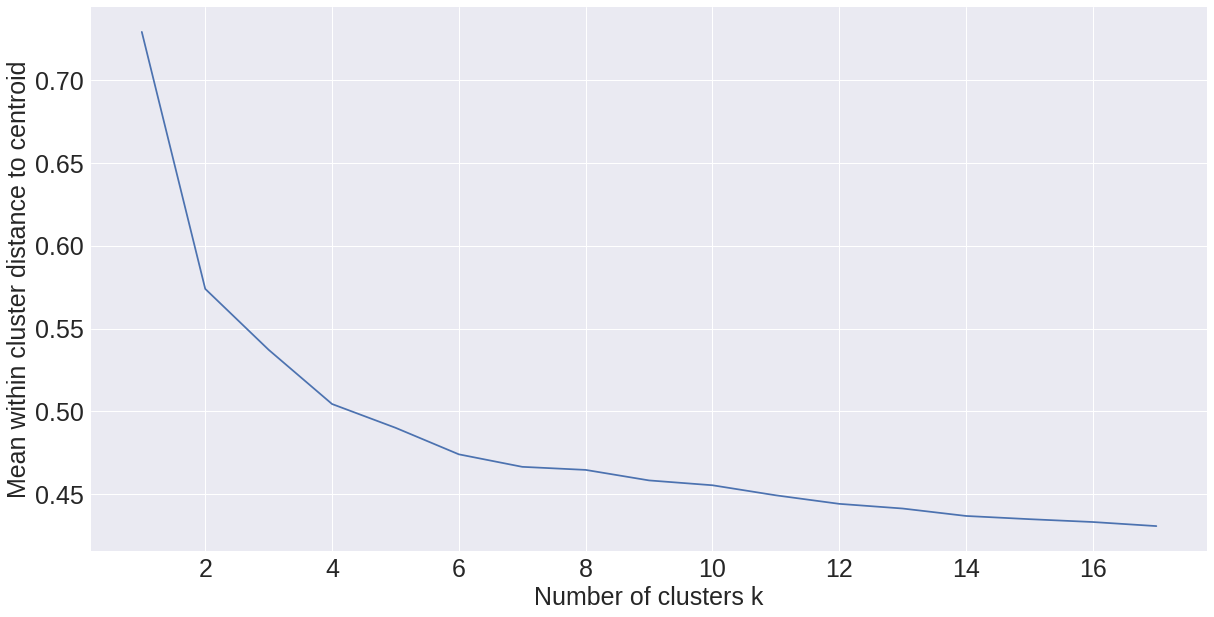

In [47]:
plt.figure(figsize=(20, 10))
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 25,
                     'xtick.labelsize' : 25,
                     'ytick.labelsize' : 25})

plt.plot(k_variations, distances)
plt.xlabel('Number of clusters k', fontsize = 25)
plt.ylabel('Mean within cluster distance to centroid', fontsize = 25)
plt.show()

# PCA of seasonal precip over the TP 

In [297]:
from sklearn.decomposition import PCA

In [298]:
file = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/GPM_IMERG_cluster_input_seasonal.nc4'
precip, lon, lat = read_in_netcdf(file)

In [299]:


#convert 3D matrix to 2D input matrix with n_gridpoints x n_features
data= np.reshape(precip, (12,351*181))
data= data.transpose()
np.shape(data)
data

array([[0.79384077, 0.21038234, 1.3307225 , ..., 0.13289794, 0.11021849,
        0.5722426 ],
       [0.77806216, 0.26074788, 1.8938541 , ..., 0.08126032, 0.17184958,
        0.59550965],
       [0.78979546, 0.23071705, 2.0568836 , ..., 0.11541067, 0.17574455,
        0.5306247 ],
       ...,
       [0.        , 0.47892457, 2.4392016 , ..., 5.0511174 , 2.029569  ,
        0.        ],
       [0.        , 0.2629072 , 1.4889611 , ..., 4.665661  , 2.0556214 ,
        0.02769067],
       [0.        , 0.03552624, 1.7328318 , ..., 4.234447  , 1.2789446 ,
        0.0666117 ]], dtype=float32)

In [300]:
pca = PCA(n_components = 2)
new = pca.fit_transform(data)  
np.shape(new[:,0])
# reshape data space back to grid 
pca1= np.reshape(new[:,0], ((351,181)))
pca2= np.reshape(new[:,1], ((351,181)))
comps= pca.components_
np.shape(comps)

(2, 12)

/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


(array([0.00015681, 0.00078407, 0.00195146, 0.00282265, 0.00270068,
        0.00294461, 0.00311885, 0.00383322, 0.00419912, 0.00473926,
        0.00466956, 0.0055059 , 0.00547105, 0.00683011, 0.00735282,
        0.0072657 , 0.00815431, 0.00839824, 0.0090255 , 0.01113377,
        0.01494957, 0.01740632, 0.01580333, 0.01812069, 0.01939262,
        0.01766767, 0.01819039, 0.01697072, 0.02083879, 0.02162286,
        0.02090849, 0.02265086, 0.02568259, 0.03218165, 0.04195637,
        0.05038946, 0.05120837, 0.05185305, 0.05197502, 0.04578959,
        0.04127684, 0.03676409, 0.0314847 , 0.02768632, 0.02340008,
        0.01883506, 0.01613438, 0.0148973 , 0.01336401, 0.01064591,
        0.01007092, 0.00853763, 0.00909519, 0.00874672, 0.00721343,
        0.00642936, 0.00569756, 0.00752706, 0.00651648, 0.00508773,
        0.00554075, 0.00507031, 0.00459987, 0.00468699, 0.00482638,
        0.00642936, 0.00663845, 0.00730055, 0.0072657 , 0.00843309,
        0.00973987, 0.00984441, 0.00801492, 0.00

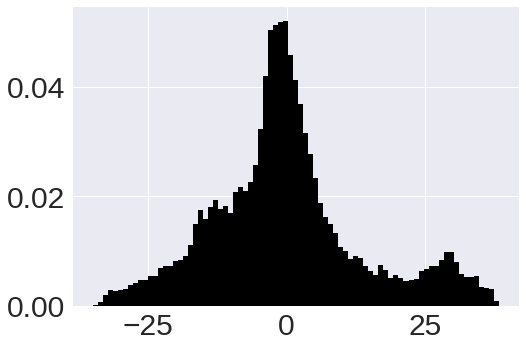

In [301]:
plt.hist(pca1.flatten(), bins= 81, color= 'k', normed = True)

In [302]:

from sklearn import preprocessing


In [303]:
# normalize principal components 

pca1_norm = preprocessing.scale(pca1)
#pca1_norm = preprocessing.normalize(pca1, norm='l1')

/home/juli/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/juli/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


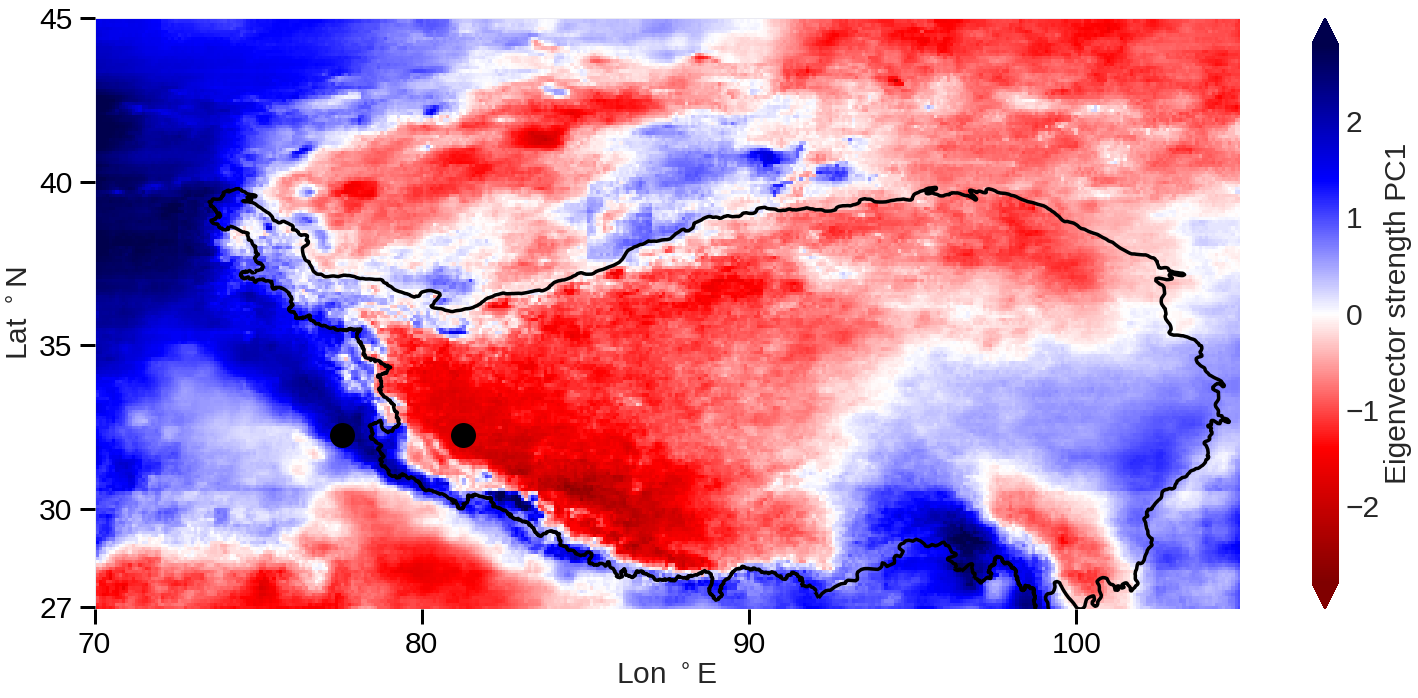

In [97]:
plt.figure(figsize=(22, 10))


cmap = plt.cm.get_cmap('seismic_r')
m = Basemap(projection='cyl', llcrnrlat=26.95, urcrnrlat= 44.95, llcrnrlon=70.05, urcrnrlon=105.0,  resolution = 'c')
lons, lats =np.meshgrid(lon, lat)
xi,yi = m(lons,lats)
Z=0 
cs = m.pcolormesh(xi,yi, pca1_norm.T, cmap = cmap, vmin= -2.8, vmax= 2.8) 


# Plot points with very different factors on map 
lo = 81.25
la = 32.25
x,y = m(lo, la)
m.plot(x, y, 'ko', markersize=25, label= 'A')

lo1 = 77.55
la1 = 32.25
x1,y1 = m(lo1, la1)
m.plot(x1, y1, 'ko', markersize=25, label= 'B')



# coordinate axes 
xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100], xlabels, fontsize=30)
plt.yticks([27,30, 35, 40, 45],ylabels, fontsize=30)
plt.xlabel('Lon $^\circ$E',  fontsize=30)
plt.ylabel('Lat $^\circ$N',  fontsize=30)
plt.tick_params(direction='out', length=15, width=3, colors='k')




# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=3.5)

cbar = plt.colorbar(extend= 'both')
cbar.set_label('Eigenvector strength PC1', fontsize= 30)
plt.tight_layout(h_pad=1)

plt.savefig('/media/juli/Elements/comparison/pc1_seasonal_.png')

# Gridspec plot

In [135]:
# find points with highest and lowest eigenvector values 

matrix = pca1_norm.T
x_max= lons[matrix == np.nanmax(matrix)][0]
y_max=  lats[matrix == np.nanmax(matrix)][0]

x_min= lons[matrix == np.nanmin(matrix)][0]
y_min=  lats[matrix == np.nanmin(matrix)][0]

lo= x_min
lo1= x_max
la= y_min
la1= y_max



In [155]:
lo = 85.05
la = 35.05
lo1= 100.05
la1 = 32.05

In [156]:
# get indices for point coordinates, to know which factor to use for reconstruction 

neg= pca1[np.where(lon == lo),np.where(lat == la)].flatten()[0]
pos= pca1[np.where(lon == lo1),np.where(lat == la1)].flatten()[0]
seasonal_pos= precip[:,np.where(lon == lo1),np.where(lat == la1)]
seasonal_neg= precip[:,np.where(lon == lo),np.where(lat == la)]
print('factors', pos, neg )

factors 2.3215332 -23.612722


In [98]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple, HandlerNpointsYoffsets, HandlerLineCollection

class HandlerDashedLines(HandlerLineCollection):
    """
    Custom Handler for LineCollection instances.
    """
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        print(xdata)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines

## average seasonal curve and PC1 around characteristic point 




In [138]:
t = np.percentile(matrix, 90)

In [139]:
# connected pixels within 90th percentile 
im= matrix
im[ im < t]= 0
s = generate_binary_structure(2,2)
contiguous_region, nr = ndimage.label(im, structure = s) # array with nr. labels of contigous pixels above threshold and nr. of total identified MCS 


In [191]:
pca1_norm = preprocessing.scale(pca1)


/home/juli/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/juli/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [192]:
# negative
lat_min= 34.05
lat_max= 36.05
lon_min= 84.05
lon_max= 86.05

matrix = preprocessing.scale(pca1).T
matrix[lons < lon_min] = 0 
matrix[lats< lat_min] = 0 
matrix[lons > lon_max] = 0 
matrix[lats > lat_max] = 0 

neg= np.nanmean(matrix)
seasonal_neg= np.nanmean(precip.T[matrix <  0], axis = 0 ) 


/home/juli/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/juli/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [193]:
# surrounding box positive 

lat_min= 31.05
lat_max= 33.05
lon_min= 99.05
lon_max= 101.05

matrix = preprocessing.scale(pca1).T
matrix[lons < lon_min] = 0 
matrix[lats < lat_min] = 0 
matrix[lons > lon_max] = 0 
matrix[lats > lat_max] = 0 

pos= np.nanmean(matrix)
seasonal_pos= np.nanmean(precip.T[matrix > 0], axis = 0 ) 

/home/juli/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/juli/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [194]:

matrix = preprocessing.scale(pca1).T

/home/juli/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/juli/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [155]:
curves = np.empty((matrix[matrix > 0 ].shape[0],12))
for idx, x  in enumerate(matrix[matrix > 0]):
     curves[idx]= pca.mean_ + x * comps[0]

In [156]:
mean_pc= np.nanmean(curves, axis = 0 )

In [130]:
factor = pca1[np.where(lon == 97.05),np.where(lat == 28.05)].flatten()[0]
mean_pc = pca.mean_ + factor * comps[0]

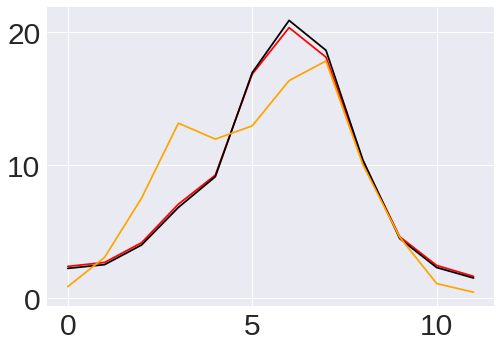

In [157]:
plt.plot(mean_pc, 'r') #  principal component (selected region average)
plt.plot(pca.mean_, 'k') #  average seasonal curve of the entire  domain (estimated from training data)
plt.plot(seasonal_neg,'orange')  # seasonal curve (selected region average)

In [280]:
# normalize principal components 

pca1_norm = preprocessing.scale(pca1)
#pca1_norm = preprocessing.normalize(pca1, norm='l1')

/home/juli/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/juli/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [184]:
### box instead of points 
def plot_rec(m, lower_left, upper_left, lower_right, upper_right):
    xs = [lower_left[0], upper_left[0],
          upper_left[0],upper_right[0],
          upper_right[0],lower_right[0],
          lower_right[0],lower_left[0]]
    ys = [lower_left[1], upper_left[1],
          upper_left[1],upper_right[1],
          upper_right[1],lower_right[1],
          lower_right[1],lower_left[1]] 
    m.plot(xs, ys, latlon = True, linestyle= '-', linewidth=5.5, color='black' )
    
    
# box domain
llcrnrlon = 84.05
urcrnrlon = 86.05
llcrnrlat = 34.05
urcrnrlat = 36.06

lower_left = (llcrnrlon, llcrnrlat)
lower_right= (urcrnrlon, llcrnrlat)
upper_left = (llcrnrlon, urcrnrlat)
upper_right= (urcrnrlon, urcrnrlat)


llcrnrlon = 99.05
urcrnrlon = 101.05
llcrnrlat = 31.05
urcrnrlat = 33.05

    
lower_left2 = (llcrnrlon, llcrnrlat)
lower_right2= (urcrnrlon, llcrnrlat)
upper_left2 = (llcrnrlon, urcrnrlat)
upper_right2= (urcrnrlon, urcrnrlat)



/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


[ 0. 60.]
[ 0. 60.]


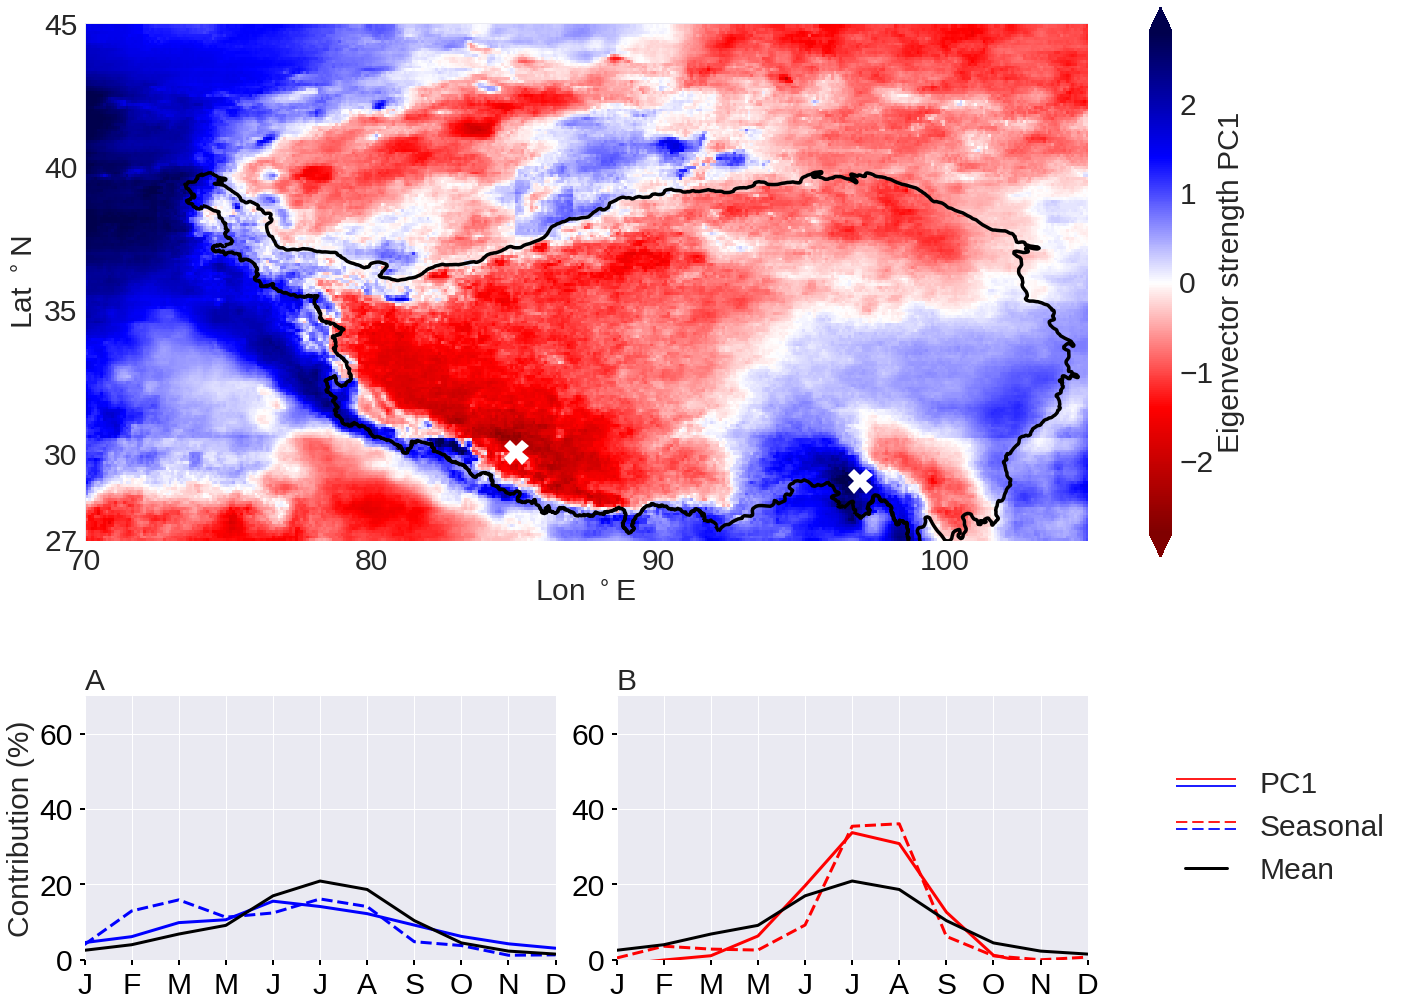

In [349]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(2, 3, height_ratios = [1.0, 0.52], width_ratios = [1.0, 1.0, 0.05])


##################SUBPLOT 1############################################
ax1 = plt.subplot(gs[0, :2])


cmap = plt.cm.get_cmap('seismic_r')
m = Basemap(projection='cyl', llcrnrlat=26.95, urcrnrlat= 44.95, llcrnrlon=70.05, urcrnrlon=105.0,  resolution = 'c')
lons, lats =np.meshgrid(lon, lat)
xi,yi = m(lons,lats)
Z=0 
cs = m.pcolormesh(xi,yi, pca1_norm.T, cmap = cmap, vmin= -2.8, vmax= 2.8) 


# Plot points with very different factors on map 


lo = 85.05
la = 30.05
x,y = m(lo, la)
#x,y = m(x_min, y_min)
m.plot(x, y, 'white', marker= 'X', markersize=25, label= 'A')

lo1 = 97.05
la1 = 29.05
x1,y1 = m(lo1, la1)
#x1,y1 = m(x_max, y_max)
m.plot(x1, y1, 'white', marker= 'X', markersize=25, label= 'B')


# coordinate axes 
xlabels=['70', '80', '90', '100']
ylabels= [ '27', '30', '35', '40', '45']

ax1.set_xticks([70, 80,90, 100])
ax1.set_yticks([27,30, 35, 40, 45])
ax1.set_xticklabels(xlabels)
ax1.set_yticklabels(ylabels)
ax1.set_xlabel('Lon $^\circ$E',  fontsize=30)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=30)


# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=3.5)


##################################################
#plot_rec(m, lower_left, upper_left, lower_right, upper_right)
#plot_rec(m, lower_left2, upper_left2, lower_right2, upper_right2)


#cbar = plt.colorbar(extend= 'both
cax = plt.subplot(gs[0, 2])
cbar= plt.colorbar(cs, orientation="vertical", pad= 0.05, extend= 'both', cax = cax)
cbar.set_label('Eigenvector strength PC1', fontsize= 30)







##################SUBPLOT2############################################
ax2 = plt.subplot(gs[-1, 0])

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 30,
                     'xtick.labelsize' : 30,
                     'ytick.labelsize' : 30})

h_r_1 = ax2.plot(pca.mean_ + pos * comps[0],  color= 'b', label = "PC1", linewidth= 3.0 )#
h_s_1 = ax2.plot(seasonal_pos.flatten(), color= 'b', linestyle= '--',  linewidth= 3.0, label= 'seasonal')
h_mean = ax2.plot(pca.mean_,  color= 'k', linestyle= '-',label = 'regional mean', linewidth= 3.0 )

ax2.set_ylabel('Contribution (%)', fontsize= 30)
labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
ax2.set_xticks(np.arange(1,12,1))
ax2.set_xticklabels(labels)
ax2.set_xlim(1,11)
ax2.set_ylim(0,65)
ax2.set_title('A', loc = "left", fontsize= 30)
ax2.set_ylim([0, 70])
ax2.set_aspect(0.08)
ax2.tick_params(direction='out', length=5, width=2, colors='k')



##################SUBPLOT 3############################################
ax3 = plt.subplot(gs[-1, 1])

h_r_2 = ax3.plot(pca.mean_ + neg * comps[0], color= 'r', label = "PC1" , linewidth= 3.0 )
h_s_2 = ax3.plot(seasonal_neg.flatten(), color= 'r', linestyle= '--',  linewidth= 3.0, label= 'seasonal')
ax3.plot(pca.mean_, color = 'k', linestyle= '-',label = 'regional mean', linewidth= 3.0 )

ax3.set_xticks(np.arange(1,12,1))
ax3.set_xticklabels(labels)
ax3.set_xlim(1,11)
ax3.set_title('B', loc = "left", fontsize= 30)
ax3.set_ylim([0, 70])
ax3.set_aspect(0.08)
ax3.tick_params(direction='out', length=5, width=2, colors='k')


lc1 = LineCollection([np.ones((5, 2)), np.ones((5, 2))], colors = ["r", "b"])
lc2 = LineCollection([np.ones((5, 2)), np.ones((5, 2))], colors = ["r", "b"], linestyles = "--")

ax = plt.subplot(gs[-1, -1])
ax.legend(handles = [lc1, lc2, h_mean[0]],
          labels = ["PC1", "Seasonal", "Mean"],
          handler_map = {LineCollection : HandlerDashedLines()},
          numpoints = 10,
          fontsize = 30,
          loc = "center left")
ax.set_axis_off()


plt.tight_layout()

plt.savefig('/media/juli/Elements/comparison/PCA1_SEASONAL_EW.png')

# reconstruction of seasonal curve (mean vector at specific point)

##  PCA_x  + mean * FACTOR (from map, pos or neg) 

In [348]:
# get indices for point coordinates, to know which factor to use for reconstruction 
means= pca.mean_
neg= pca1[np.where(lon == lo),np.where(lat == la)].flatten()[0]
pos= pca1[np.where(lon == lo1),np.where(lat == la1)].flatten()[0]
seasonal_pos= precip[:,np.where(lon == lo1),np.where(lat == la1)]
seasonal_neg= precip[:,np.where(lon == lo),np.where(lat == la)]
print('factors', pos, neg )

factors 11.094743 -21.06354


In [147]:
idx1= np.where(lats == la)[0][1]
idx2= np.where(lons == lo)[1][0]
idx3= np.where(lats == la1)[0][1]
idx4= np.where(lons == lo1)[1][0]

neg= pca1.T[idx1,idx2].flatten()[0]
pos= pca1.T[idx3,idx4].flatten()[0]

#pos= pca1.T[np.where(lons == lo1)[1][0],np.where(lats == la1)][1][0].flatten()[0]
print(pos, neg)


6.808265 -33.69229


In [151]:
idx1= np.where(lats == la1)[0][1]
idx2= np.where(lons == lo1)[1][0]
seasonal_pos = precip[:, idx2,idx1]
idx1= np.where(lats == la)[0][1]
idx2= np.where(lons == lo)[1][0]
seasonal_neg = precip[:,idx2,idx1]

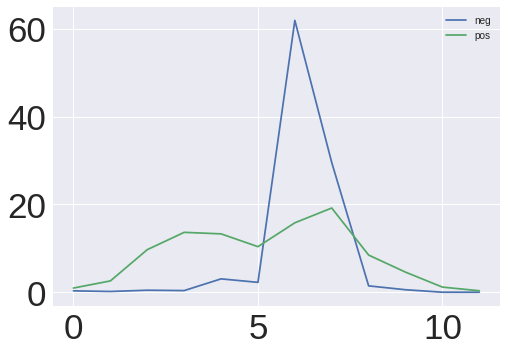

In [154]:
plt.plot(seasonal_neg.flatten(), label= 'neg')
plt.plot(seasonal_pos.flatten(), label='pos')
plt.legend()

/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.
/home/juli/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/juli/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: 
The dedent function was depreca

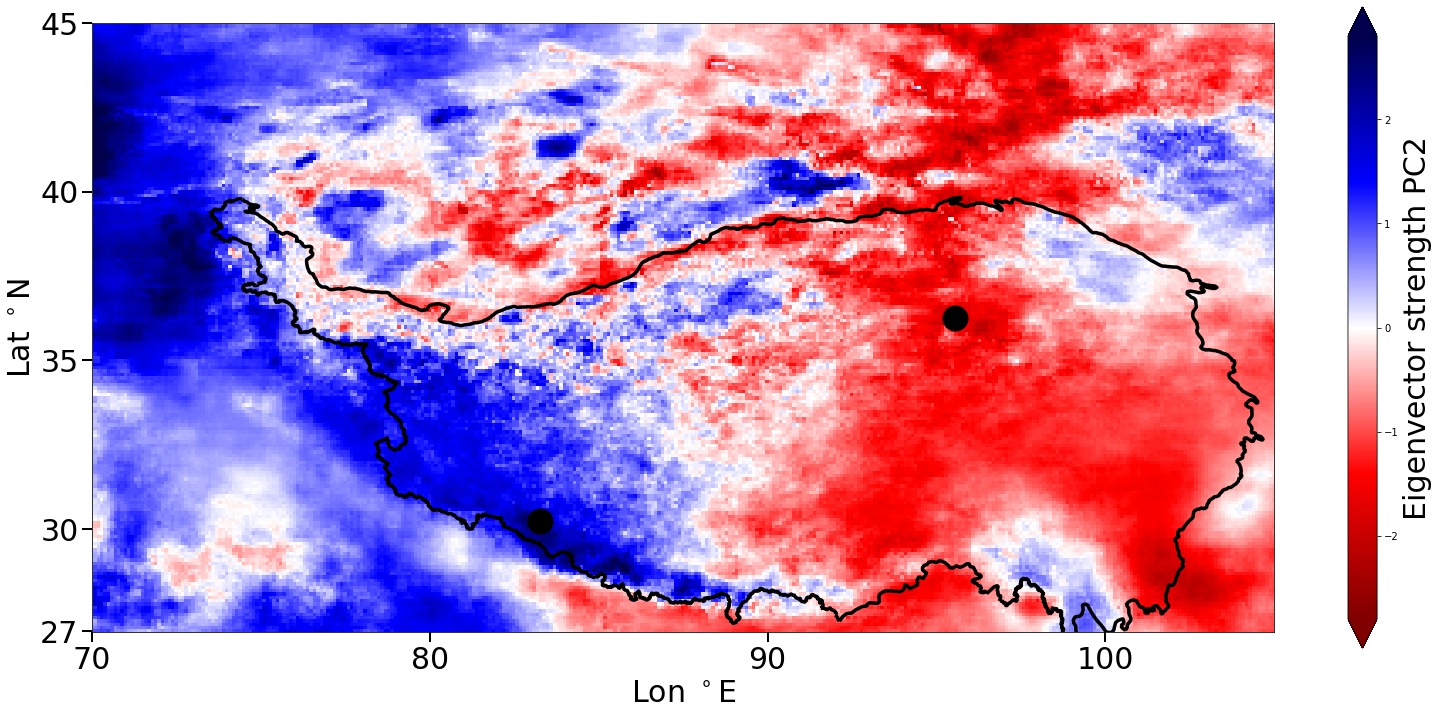

In [13]:
#pca2= np.reshape(new[:,1], ((351,181)))
plt.figure(figsize=(22, 10))
cmap = plt.cm.get_cmap('seismic_r')
m = Basemap(projection='cyl', llcrnrlat=26.95, urcrnrlat= 44.95, llcrnrlon=70.05, urcrnrlon=105.0,  resolution = 'c')
lons, lats =np.meshgrid(lon, lat)
xi,yi = m(lons,lats)
cs = m.pcolormesh(xi,yi, preprocessing.scale(pca2).T, cmap = cmap, vmin = -2.8, vmax = 2.8) 
#cs = m.pcolormesh(xi,yi, pca2.T, cmap = cmap) 


cbar = plt.colorbar(extend= 'both')
cbar.set_label('Eigenvector strength PC2', fontsize= 30)

# coordinate axes 
xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100], xlabels, fontsize=30)
plt.yticks([27,30, 35, 40, 45],ylabels, fontsize=30)
plt.xlabel('Lon $^\circ$E',  fontsize=30)
plt.ylabel('Lat $^\circ$N',  fontsize=30)
plt.tick_params(direction='out', length=10, width=2, colors='k')



# Plot points with very different factors on map 
# BLUE
lo = 83.25
la = 30.25
x,y = m(lo, la)
m.plot(x, y, 'ko', markersize=25, label= 'A')

# RED
lo1 = 95.55
la1 = 36.25
x1,y1 = m(lo1, la1)
m.plot(x1, y1, 'ko', markersize=25, label= 'B')


# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=3.5)


plt.tight_layout(h_pad=1)

plt.savefig('/media/juli/Elements/comparison/seasonal_PC2.png')

In [14]:
# attributes of PC instance 
comps= pca.components_ # direction of max variance, sorted by explained variance, shape = n components x n features 
var= pca.explained_variance_ratio_ # how much of the variance (%)is explained by each component (shape = n components)
pca.singular_values_ # shape = n_components
means = pca.mean_ # shape = n_features 


In [15]:
# explained variances 
var

array([0.52826744, 0.21775094], dtype=float32)

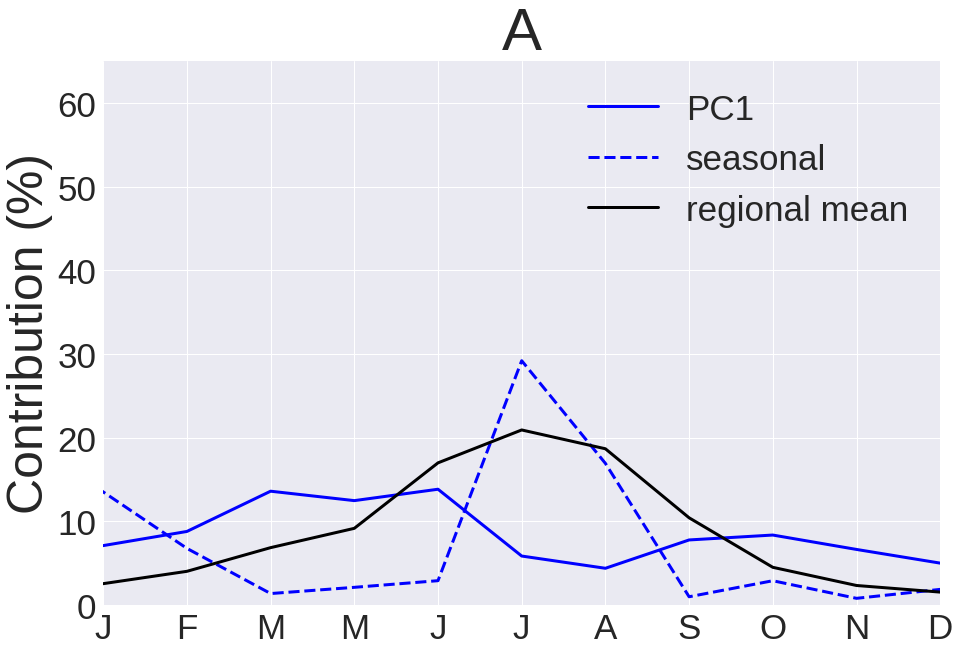

In [104]:

# Reconstruction of seasonal curves, PCA 1 

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 35,
                     'xtick.labelsize' : 35,
                     'ytick.labelsize' : 35})
plt.figure(figsize=(15, 10))


plt.plot(means + pos * comps[0],  color= 'b', label = "PC1", linewidth= 3.0 )
plt.plot(seasonal_pos.flatten(), color= 'b', linestyle= '--',  linewidth= 3.0, label= 'seasonal')
plt.plot(means,  color= 'k', label = 'regional mean', linewidth= 3.0 )

plt.ylabel('Contribution (%)', fontsize= 50)
labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(1,12,1), labels)
plt.xlim(1,11)
plt.ylim(0,65)
plt.title('A', fontsize= 60)

plt.legend( prop={'size': 35})
#plt.figure()

plt.savefig('/media/juli/Elements/comparison/reconstructed_pca1_seasonal_pos.png')


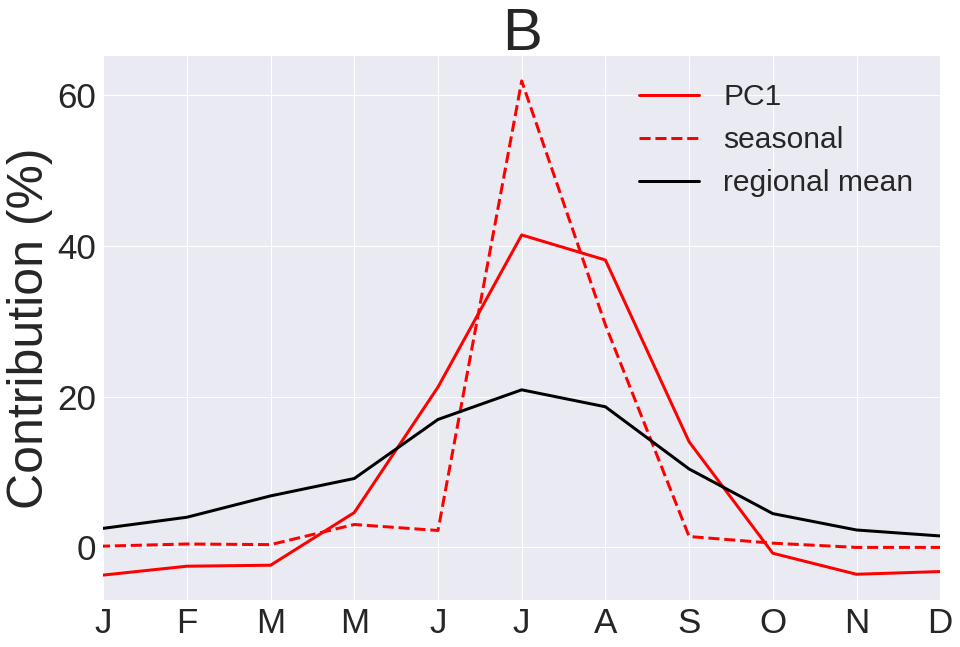

In [741]:
# Reconstruction of seasonal curves, PCA 1 

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 35,
                     'xtick.labelsize' : 35,
                     'ytick.labelsize' : 35})
plt.figure(figsize=(15, 10))

plt.plot(means + neg * comps[0], color= 'r', label = "PC1" , linewidth= 3.0 )
plt.plot(seasonal_neg.flatten(), color= 'r', linestyle= '--',  linewidth= 3.0, label= 'seasonal')
plt.plot(means, color = 'k', label = 'regional mean', linewidth= 3.0 )

plt.ylabel('Contribution (%)', fontsize= 50)
labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(1,12,1), labels)
plt.xlim(1,11)
plt.title('B', fontsize= 60)

plt.legend( prop={'size': 30})
#plt.figure()

plt.savefig('/media/juli/Elements/comparison/reconstructed_pca1_seasonal_neg.png')

In [105]:
t = pca1[np.where(lon == lo),np.where(lat == la)].flatten()[0]
t2= pca1[np.where(lon == lo1),np.where(lat == la1)].flatten()[0]
print(t,t2)

-33.692303 6.8082623


In [206]:
# find points with highest and lowest eigenvector values within TP boundary 

# extract only values above 3000 m a.s.l. 
def read_in_netcdf_dem(file):
    dataset = Dataset(file)    
    dem= np.array(dataset["__xarray_dataarray_variable__"])
    dataset.close()
    return dem

dem = read_in_netcdf_dem('/media/juli/Data/master_thesis/Master_thesis/data/DEM_TP.tif/dem_GPM_format.nc')

matrix = preprocessing.scale(pca2).T
matrix[dem < 3000 ] = 0 

x_max= lons[matrix == np.nanmax(matrix)][0]
y_max=  lats[matrix == np.nanmax(matrix)][0]

x_min= lons[matrix == np.nanmin(matrix)][0]
y_min= lats[matrix == np.nanmin(matrix)][0]

lo= x_min
lo1= x_max
la= y_min
la1= y_max


/home/juli/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/juli/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [216]:
print(x_min, y_min, x_max, y_max)

91.75 37.55 73.35 37.75


In [217]:
# get indices for point coordinates, to know which factor to use for reconstruction 

neg= pca2[np.where(lon == lo),np.where(lat == la)].flatten()[0]
pos= pca2[np.where(lon == lo1),np.where(lat == la1)].flatten()[0]
seasonal_pos= precip[:, np.where(lon == lo),np.where(lat == la)]
seasonal_neg= precip[:, np.where(lon == lo1),np.where(lat == la1)]
print('factors', pos, neg )

factors 20.947685 -23.5256


In [107]:
pos1= pca1[np.where(lon == lo),np.where(lat == la)].flatten()[0]
neg1= pca1[np.where(lon == lo1),np.where(lat == la1)].flatten()[0]
print(pos1,neg1)

1.5316476 -0.8919265


array([ 8.230258 ,  8.034073 , 11.029964 ,  7.264801 ,  4.492007 ,
       -1.9780121, 28.409863 , 21.4024   ,  3.697432 ,  3.0605602,
        3.0258422,  3.3308127], dtype=float32)

24.721348

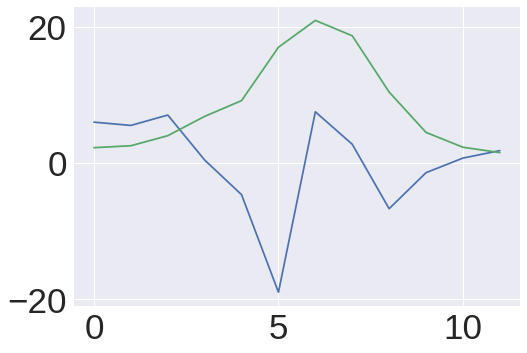

In [109]:
plt.plot(pos * comps[1])
plt.plot(means)
pos

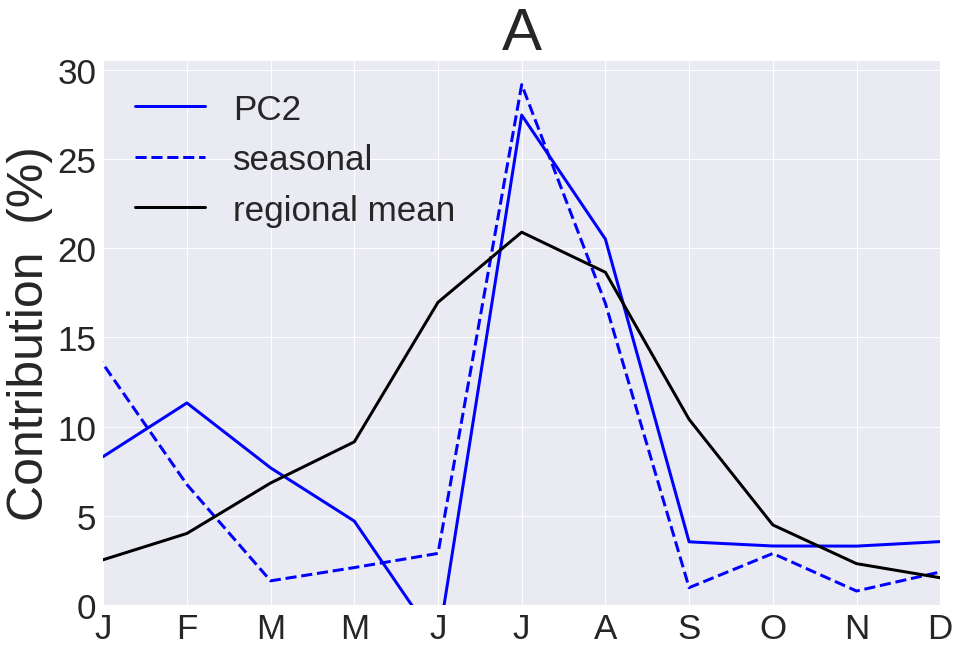

In [110]:
# Reconstruction of seasonal curves, PCA 2 

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 35,
                     'xtick.labelsize' : 35,
                     'ytick.labelsize' : 35})
plt.figure(figsize=(15, 10))


plt.plot(means + pos1 * comps[0] +pos * comps[1], color= 'b', label = "PC2", linewidth= 3.0 )
plt.plot(seasonal_pos.flatten(), color= 'b', linestyle= '--',  linewidth= 3.0, label= 'seasonal')
plt.plot(means,color= 'k',  label = 'regional mean', linewidth= 3.0 )


plt.legend( prop={'size': 35})

plt.ylabel('Contribution  (%)', fontsize= 50)
labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(1,12,1), labels)
plt.xlim(1,11)
plt.ylim(0,30.5)
plt.title('A', fontsize= 60)

#plt.figure()

plt.savefig('/media/juli/Elements/comparison/reconstructed_pca2_seasonal_pos.png')

In [100]:
# Reconstruction of seasonal curves, PCA 2 

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 35,
                     'xtick.labelsize' : 35,
                     'ytick.labelsize' : 35})
plt.figure(figsize=(15, 10))


plt.plot(means + neg * comps[1], color= 'r', label = "PC2", linewidth= 3.0 )
plt.plot(seasonal_neg.flatten(), color= 'r', linestyle= '--',  linewidth= 3.0, label= 'seasonal')
plt.plot(means,color= 'k',  label = 'regional mean', linewidth= 3.0 )
plt.legend( prop={'size': 35})

plt.ylabel('Contribution (%)', fontsize= 50)
labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
plt.xticks(np.arange(1,12,1), labels)
plt.xlim(1,11)
plt.title('B', fontsize= 60)

#plt.figure()

plt.savefig('/media/juli/Elements/comparison/reconstructed_pca2_seasonal_neg.png')

NameError: name 'means' is not defined

<Figure size 1080x720 with 0 Axes>

In [350]:
lo1 = 97.05
la1 = 35.05
lo = 83.05
la = 30.55

In [351]:
# get indices for point coordinates, to know which factor to use for reconstruction 

pos= pca2[np.where(lon == lo),np.where(lat == la)].flatten()[0]
neg= pca2[np.where(lon == lo1),np.where(lat == la1)].flatten()[0]
seasonal_pos= precip[:, np.where(lon == lo),np.where(lat == la)]
seasonal_neg= precip[:, np.where(lon == lo1),np.where(lat == la1)]
print('factors', pos, neg )

factors 19.71748 -3.5538435


In [331]:
# find points with highest and lowest eigenvector values within TP boundary 

# extract only values above 3000 m a.s.l. 
def read_in_netcdf_dem(file):
    dataset = Dataset(file)    
    dem= np.array(dataset["__xarray_dataarray_variable__"])
    dataset.close()
    return dem

dem = read_in_netcdf_dem('/media/juli/Data/master_thesis/Master_thesis/data/DEM_TP.tif/dem_GPM_format.nc')

matrix = preprocessing.scale(pca2).T
matrix[dem < 3000 ] = 0 

x_max= lons[matrix == np.nanmax(matrix)][0]
y_max=  lats[matrix == np.nanmax(matrix)][0]

x_min= lons[matrix == np.nanmin(matrix)][0]
y_min= lats[matrix == np.nanmin(matrix)][0]

lo= x_min
#lo1= x_max
la= y_min
#la1= y_max


/home/juli/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/juli/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/home/juli/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/juli/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be re

[ 0. 60.]
[ 0. 60.]


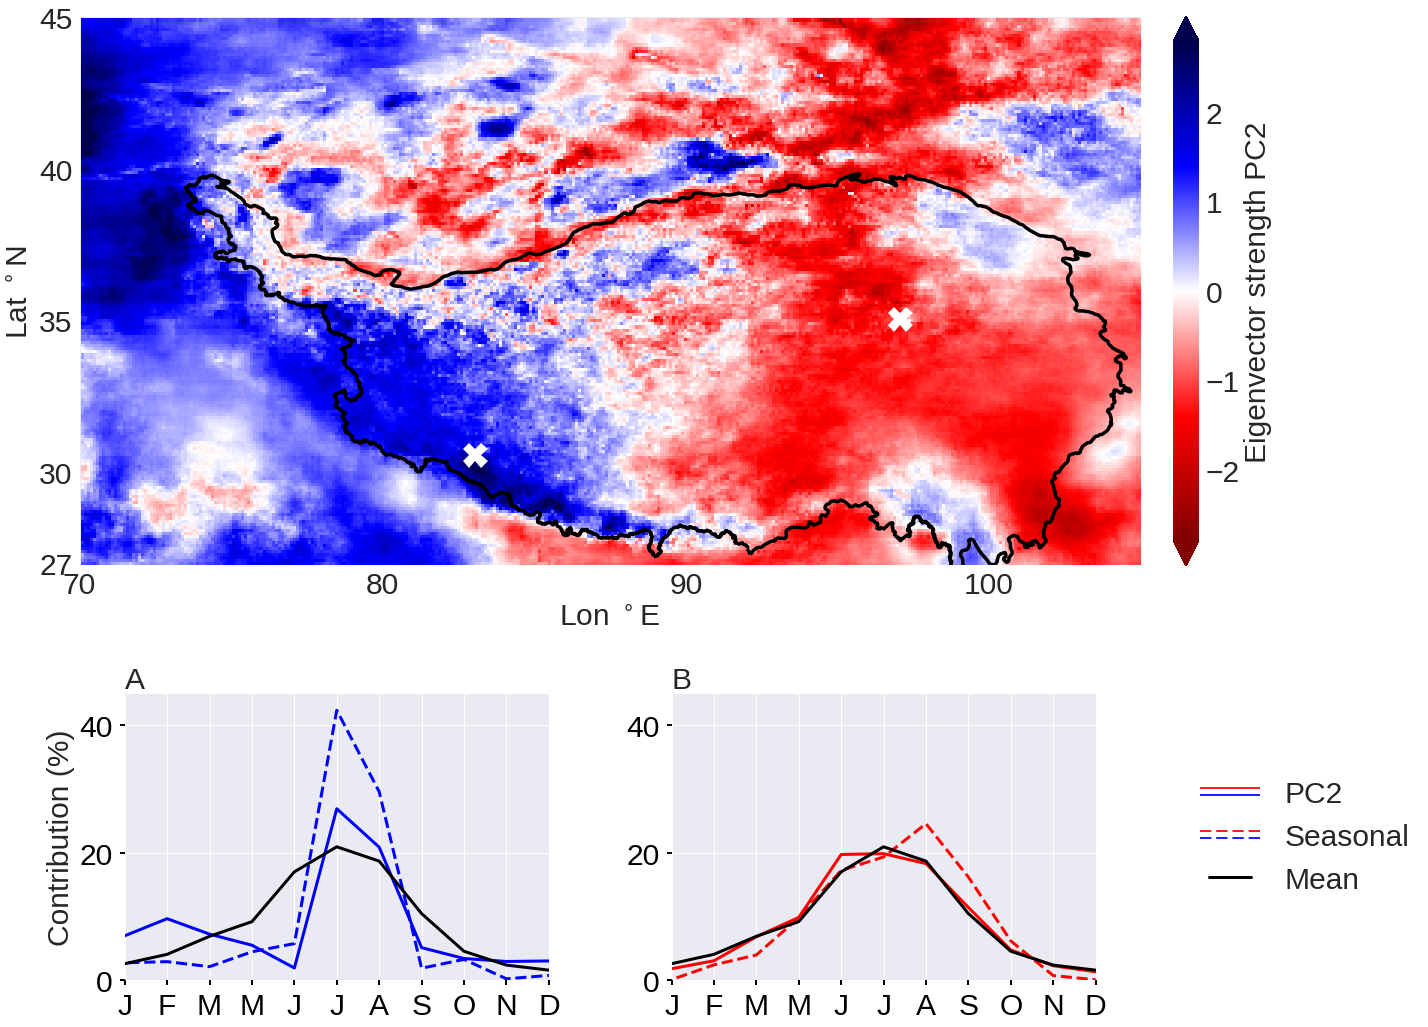

In [352]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(2, 3, height_ratios = [1.0, 0.52], width_ratios = [1.0, 1.0, 0.05])


##################SUBPLOT 1############################################
ax1 = plt.subplot(gs[0, :2])


cmap = plt.cm.get_cmap('seismic_r')
m = Basemap(projection='cyl', llcrnrlat=26.95, urcrnrlat= 44.95, llcrnrlon=70.05, urcrnrlon=105.0,  resolution = 'c')
lons, lats =np.meshgrid(lon, lat)
xi,yi = m(lons,lats)
Z=0 
cs = m.pcolormesh(xi,yi,  preprocessing.scale(pca2).T, cmap = cmap, vmin= -2.8, vmax= 2.8) 



# Plot points with very different factors on map 
# BLUE
#lo = 83.25
#la = 30.25
x,y = m(lo, la)
#x,y = m(x_max, y_max)
m.plot(x, y, 'white',   marker= 'X', markersize=25, label= 'A')

# RED
#lo1 = 95.55
#la1 = 36.25
x1,y1 = m(lo1, la1)
#x1,y1 = m(x_min, y_min)
m.plot(x1, y1, 'white',  marker= 'X', markersize=25, label= 'B')

# coordinate axes 
xlabels=['70', '80', '90', '100']
ylabels= [ '27', '30', '35', '40', '45']

ax1.set_xticks([70, 80,90, 100])
ax1.set_yticks([27,30, 35, 40, 45])
ax1.set_xticklabels(xlabels)
ax1.set_yticklabels(ylabels)
ax1.set_xlabel('Lon $^\circ$E',  fontsize=30)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=30)


# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=3.5)

#cbar = plt.colorbar(extend= 'both
cax = plt.subplot(gs[0, 2])
cbar= plt.colorbar(cs, orientation="vertical", pad= 0.05, extend= 'both', cax = cax)
cbar.set_label('Eigenvector strength PC2', fontsize= 30)



##################SUBPLOT2############################################
ax2 = plt.subplot(gs[-1, 0])

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 30,
                     'xtick.labelsize' : 30,
                     'ytick.labelsize' : 30})

h_r_1 = ax2.plot(pca.mean_ + pos * comps[1],  color= 'b', label = "PC1", linewidth= 3.0 )
h_s_1 = ax2.plot(seasonal_pos.flatten(), color= 'b', linestyle= '--',  linewidth= 3.0, label= 'seasonal')
h_mean = ax2.plot(pca.mean_,  color= 'k', label = 'regional mean', linewidth= 3.0 )

ax2.set_ylabel('Contribution (%)', fontsize= 30)
labels= ['J', 'F', 'M','M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
ax2.set_xticks(np.arange(1,12,1))
ax2.set_xticklabels(labels)
ax2.set_xlim(1,11)
ax2.set_ylim(0,65)
ax2.set_title('A', loc = "left", fontsize= 30)
ax2.set_ylim([0, 45])
ax2.set_aspect(0.15)
ax2.tick_params(direction='out', length=5, width=2, colors='k')



##################SUBPLOT 3############################################
ax3 = plt.subplot(gs[-1, 1])

h_r_2 = ax3.plot(pca.mean_ + neg * comps[1], color= 'r', label = "PC1" , linewidth= 3.0 )
h_s_2 = ax3.plot(seasonal_neg.flatten(), color= 'r', linestyle= '--',  linewidth= 3.0, label= 'seasonal')
ax3.plot(pca.mean_, color = 'k', label = 'regional mean', linewidth= 3.0 )

ax3.set_xticks(np.arange(1,12,1))
ax3.set_xticklabels(labels)
ax3.set_xlim(1,11)
ax3.set_title('B', loc = "left", fontsize= 30)
ax3.set_ylim([0, 45])
ax3.set_aspect(0.15)
ax3.tick_params(direction='out', length=5, width=2, colors='k')



lc1 = LineCollection([np.ones((5, 2)), np.ones((5, 2))], colors = ["r", "b"])
lc2 = LineCollection([np.ones((5, 2)), np.ones((5, 2))], colors = ["r", "b"], linestyles = "--")

ax = plt.subplot(gs[-1, -1])
ax.legend(handles = [lc1, lc2, h_mean[0]],
          labels = ["PC2", "Seasonal", "Mean"],
          handler_map = {LineCollection : HandlerDashedLines()},
          numpoints = 10,
          fontsize = 30,
          loc = "center left")
ax.set_axis_off()


plt.tight_layout()

plt.savefig('/media/juli/Elements/comparison/PCA2_SEASONAL_EW.png')


# PCA heatmap - looking for clusters 

## plot histogram of PCA1 vs. PCA2 to see whether clusters appear

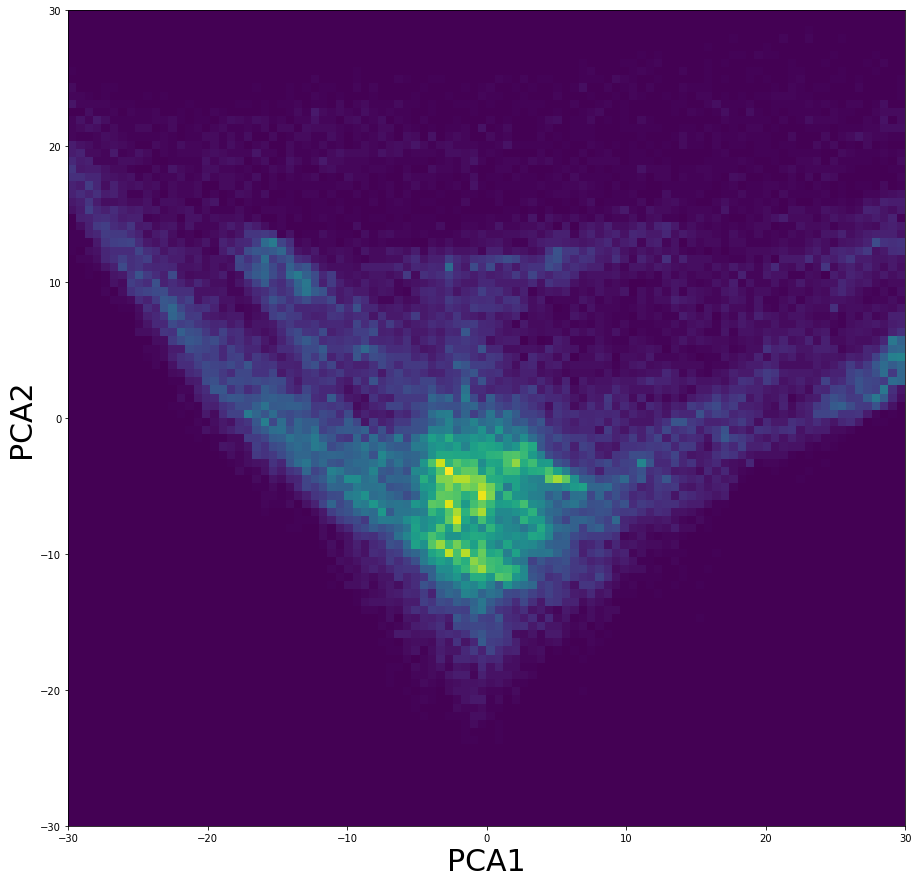

In [20]:
plt.figure(figsize = ((15,15)))

pca1= pca1.flatten()
pca2= pca2.flatten()
plt.hist2d(pca1, pca2, bins = np.linspace(-30, 30, 101) )
plt.xlabel('PCA1', fontsize= '30')
plt.ylabel('PCA2', fontsize= '30')
plt.show()

## no real clusters visible! 

In [244]:
cov = pca.get_covariance()


(12, 12)

 - domain dependency  is rather a problem from time series analysis 
 - eigenvectors* PC + mean to reconstruct curve 
 - PC show deviation from mean curve 
 - PCA heatmap, plot PCA1 and PCA2 against each other and their frequencies in order to see whether you can find any clusters (see above) 

 

## PCA diurnal

In [353]:
file = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/daily_files/GPM_IMERG_cluster_input_diurnal.nc4'
precip, lon, lat = read_in_netcdf(file)

In [354]:
precip= precip*100 
np.shape(precip)

(48, 351, 181)

In [355]:
# calculate hourly instead of 30 min 
precip_avg= np.zeros((351,181))
i=0 
for idx, row in enumerate(precip[:,:]):
    if (i % 2) == 0:
        a = np.nansum([row, precip[:,:][idx]], axis = 0)
        #print(idx, np.shape(a))
        precip_avg= np.concatenate((precip_avg, a),axis =0)
    i+=1


In [356]:
new = np.reshape(precip_avg,(25,351,181))
precip = new[1::,:,:]
np.shape(precip)

(24, 351, 181)

In [357]:
np.sum(precip[:,1,1])

104.40866839885712

In [358]:
#convert 3D matrix to 2D input matrix with n_gridpoints x n_features
data= np.reshape(precip, (24,351*181))
data= data.transpose()
np.shape(data)
data

array([[3.46317625, 1.20641434, 0.32187253, ..., 2.04255271, 2.39563441,
        1.92686915],
       [2.55462384, 2.68691373, 0.48765746, ..., 1.00291872, 3.17110085,
        5.17100906],
       [4.51381779, 1.66119063, 0.63981086, ..., 1.46901512, 1.68823707,
        4.98059034],
       ...,
       [3.81819987, 2.00407791, 2.76321006, ..., 4.88978863, 6.29541206,
        4.60281944],
       [3.06068516, 2.68843627, 4.51290464, ..., 5.78473425, 7.20388985,
        3.20985699],
       [4.94787264, 3.78016019, 2.56567979, ..., 4.5072608 , 7.00561333,
        3.47599769]])

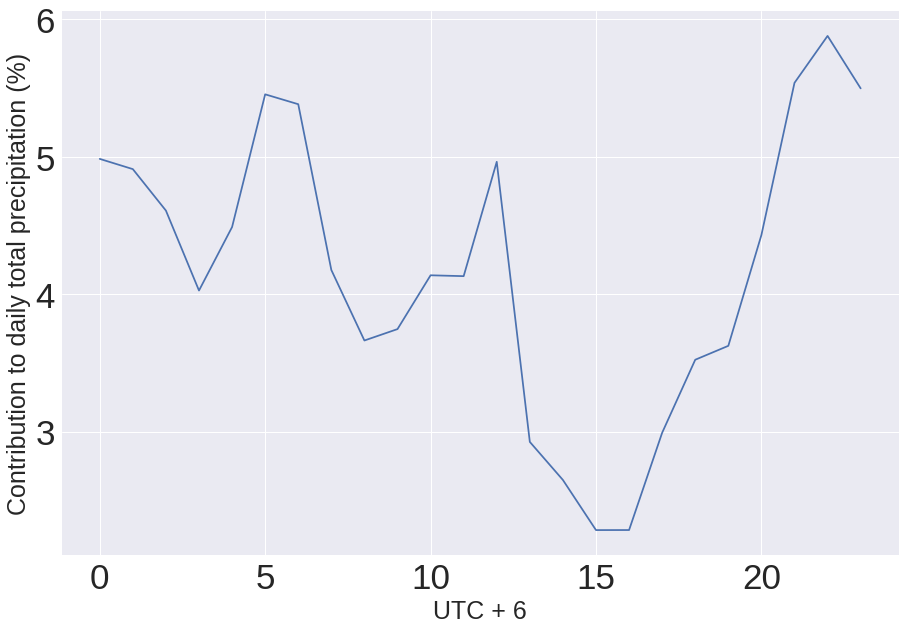

In [261]:
## mean curve 
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 35,
                     'xtick.labelsize' : 35,
                     'ytick.labelsize' : 35})
plt.figure(figsize=(15, 10))


mean = np.nanmean(precip, axis=(1, 2))
localtime=np.array(())
localtime=np.append(localtime, mean[12:24])
localtime=np.append(localtime, mean[0:12])
plt.ylabel('Contribution to daily total precipitation (%)', fontsize = 25)
plt.xlabel('UTC + 6', fontsize = 25)
plt.plot(localtime)
plt.show()


In [364]:
pca = PCA()
#pca.fit(data)
#comps= pca.components_
#np.shape(comps)

pca = PCA(n_components = 2)
new = pca.fit_transform(data)  
np.shape(new[:,0])
# reshape data space back to grid 
pca1= np.reshape(new[:,0], ((351,181)))
pca2= np.reshape(new[:,1], ((351,181)))

In [365]:
pca.explained_variance_

array([34.4401737 , 10.50170485])

/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


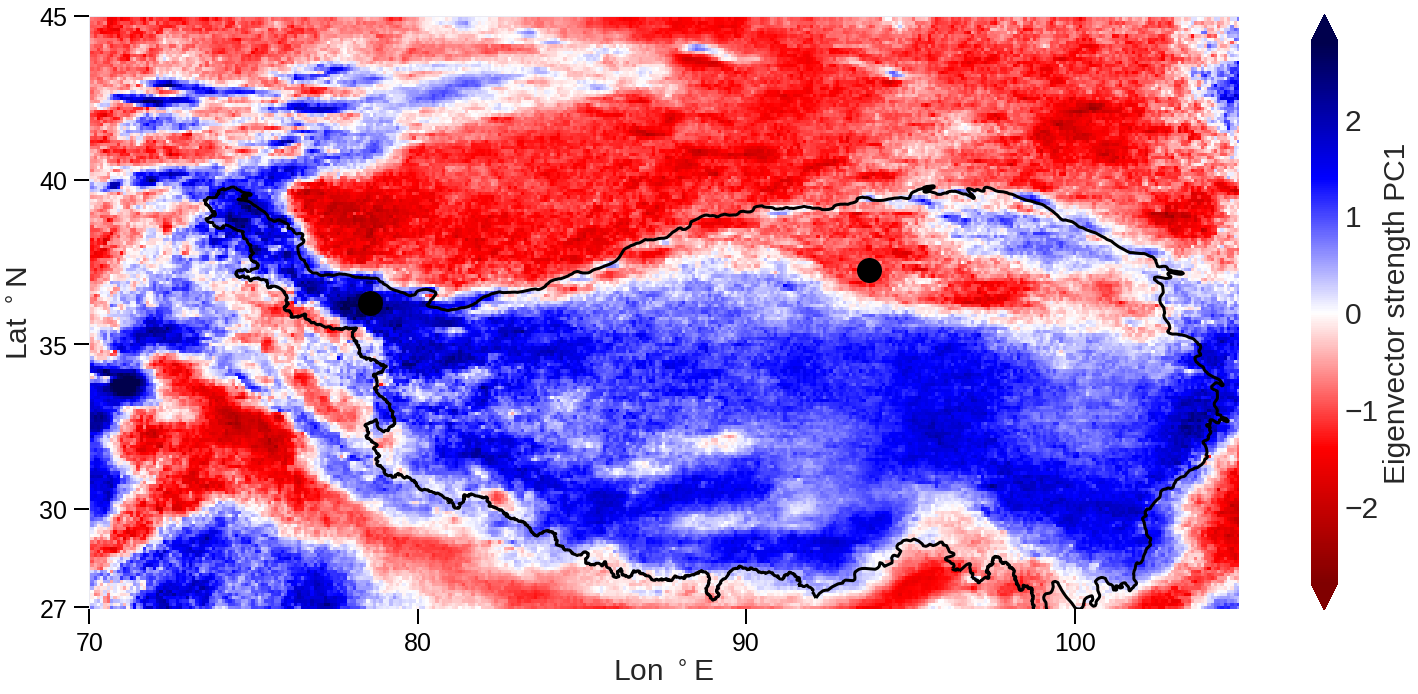

In [383]:
# grid plot
plt.figure(figsize=(22,10))

cmap = plt.cm.get_cmap('seismic_r')
m = Basemap(projection='cyl', llcrnrlat=26.95, urcrnrlat= 44.95, llcrnrlon=70.05, urcrnrlon=105.0,  resolution = 'c')
lons, lats =np.meshgrid(lon, lat)
xi,yi = m(lons,lats)
cs = m.pcolormesh(xi,yi,  preprocessing.scale(pca1.T) , cmap = cmap,  vmin = -2.8, vmax = 2.8)
#s = m.pcolormesh(xi,yi,  pca1.T , cmap = cmap )



# coordinate axes 
xlabels=[70, 80, 90, 100]
ylabels= [ 27, 30, 35, 40, 45]

plt.xticks([70, 80,90, 100], xlabels, fontsize=25)
plt.yticks([27,30, 35, 40, 45],ylabels, fontsize=25)
plt.xlabel('Lon $^\circ$E',  fontsize=30)
plt.ylabel('Lat $^\circ$N',  fontsize=30)
plt.tick_params(direction='out', length=15, width=2, colors='k')


# Plot points with very different factors on map 
# BLUE
lo = 78.55
la = 36.25
x,y = m(lo, la)
m.plot(x, y, 'ko', markersize=25, label= 'A')


# RED 
lo1 = 93.75
la1 = 37.25
x1,y1 = m(lo1, la1)
m.plot(x1, y1, 'ko', markersize=25, label= 'B')



cbar = plt.colorbar(extend= 'both')
cbar.set_label('Eigenvector strength PC1' , fontsize= 30)
                     
               
# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=3.0)

plt.tight_layout(h_pad=1)

plt.savefig('/media/juli/Elements/comparison/diurnal_first_pc_.png')

In [376]:
# get indices for point coordinates, to know which factor to use for reconstruction 

pos= pca1[np.where(lon == lo),np.where(lat == la)].flatten()[0]
neg= pca1[np.where(lon == lo1),np.where(lat == la1)].flatten()[0]
diurnal_pos= precip[:, np.where(lon == lo),np.where(lat == la)]
diurnal_neg= precip[:, np.where(lon == lo1),np.where(lat == la1)]
print('factors', pos, neg )

factors 7.535238049892868 -6.48900089639609


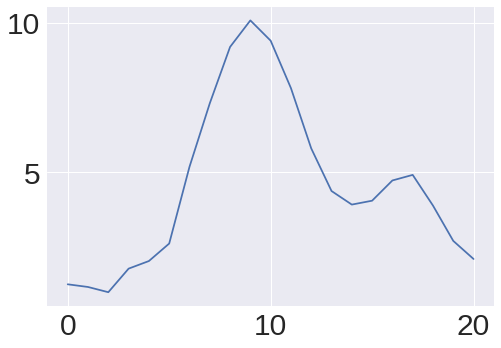

In [368]:
### smooth diurnal curve!! 

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


smooth = moving_average(diurnal_pos.flatten(), n=4)
plt.plot(smooth)

In [369]:
x1= np.linspace(0,1,24)
x2 = np.linspace(0, 1, np.shape(smooth)[0])
smooth2 = moving_average(diurnal_neg.flatten(), n=4)
np.shape( pca.mean_ + pos * pca.components_[0])

(24,)

In [370]:
pca.explained_variance_

array([34.4401737 , 10.50170485])

In [378]:
# find points with highest and lowest eigenvector values within TP boundary 

# extract only values above 3000 m a.s.l. 
def read_in_netcdf_dem(file):
    dataset = Dataset(file)    
    dem= np.array(dataset["__xarray_dataarray_variable__"])
    dataset.close()
    return dem

dem = read_in_netcdf_dem('/media/juli/Data/master_thesis/Master_thesis/data/DEM_TP.tif/dem_GPM_format.nc')

matrix = preprocessing.scale(pca1).T
matrix[dem < 3500 ] = 0 

x_max= lons[matrix == np.nanmax(matrix)][0]
y_max=  lats[matrix == np.nanmax(matrix)][0]

x_min= lons[matrix == np.nanmin(matrix)][0]
y_min= lats[matrix == np.nanmin(matrix)][0]

lo1= 94.95
lo= 79.05
la1= 38.05
la= 35.05


In [379]:
# get indices for point coordinates, to know which factor to use for reconstruction 

pos= pca1[np.where(lon == lo),np.where(lat == la)].flatten()[0]
neg= pca1[np.where(lon == lo1),np.where(lat == la1)].flatten()[0]
diurnal_pos= precip[:, np.where(lon == lo),np.where(lat == la)]
diurnal_neg= precip[:, np.where(lon == lo1),np.where(lat == la1)]
print('factors', pos, neg )

factors 7.535238049892868 -6.48900089639609


In [382]:
pca.mean_.shape

(24,)

/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/home/juli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


[ 0. 60.]
[ 0. 60.]


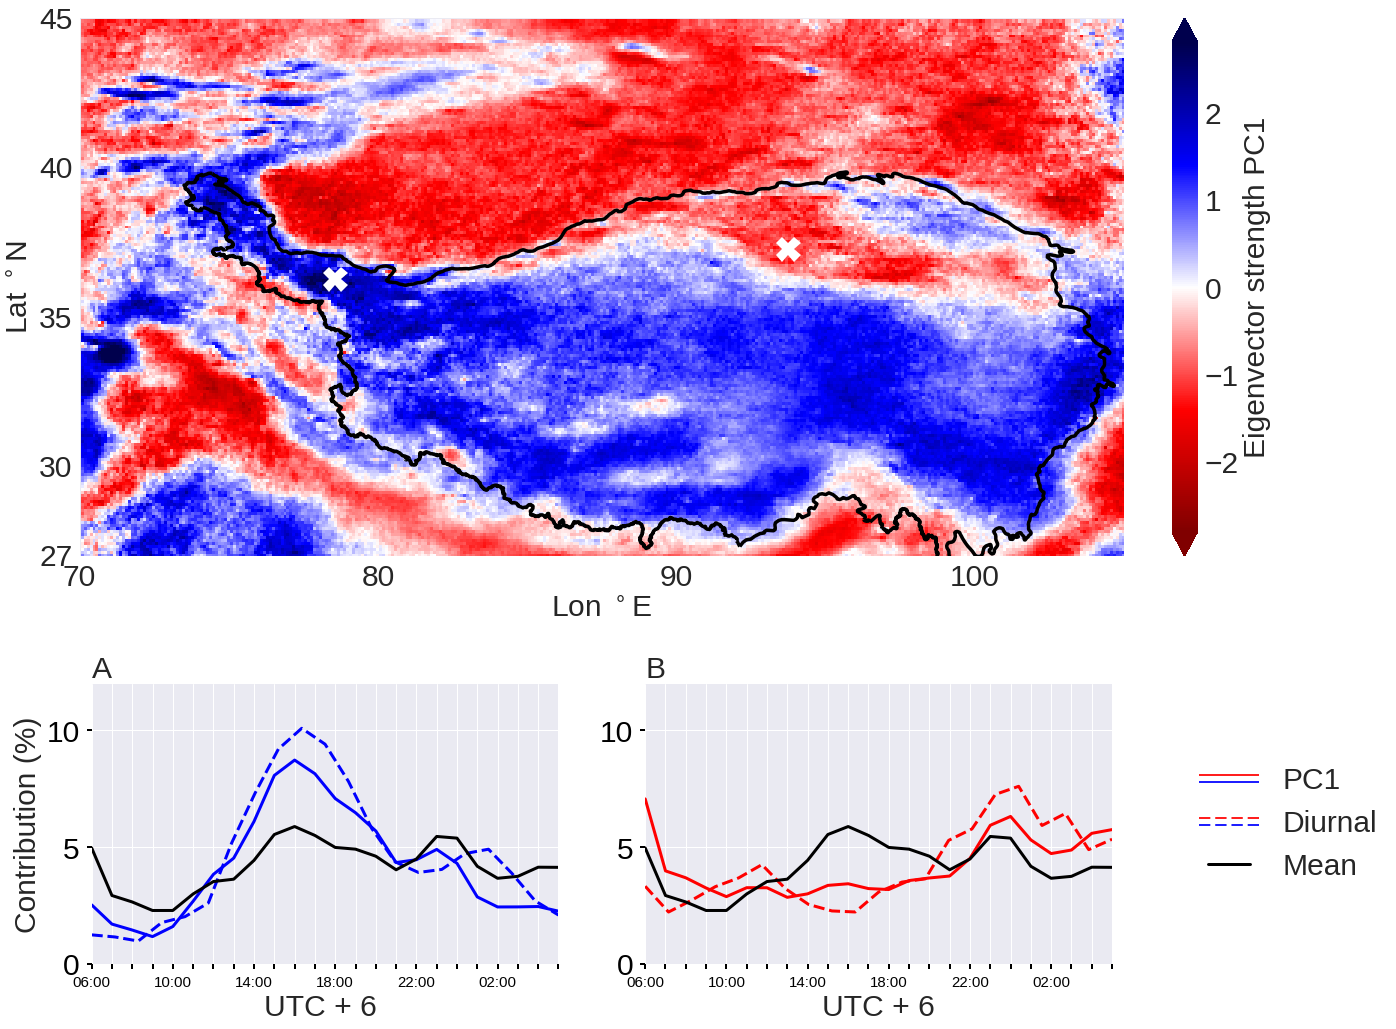

In [385]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(2, 3, height_ratios = [1.0, 0.52], width_ratios = [1.0, 1.0, 0.05])


##################SUBPLOT 1############################################
ax1 = plt.subplot(gs[0, :2])


cmap = plt.cm.get_cmap('seismic_r')
m = Basemap(projection='cyl', llcrnrlat=26.95, urcrnrlat= 44.95, llcrnrlon=70.05, urcrnrlon=105.0,  resolution = 'c')
lons, lats =np.meshgrid(lon, lat)
xi,yi = m(lons,lats)
Z=0 
cs = m.pcolormesh(xi,yi, preprocessing.scale(pca1.T), cmap = cmap, vmin= -2.8, vmax= 2.8) 


# Plot points with very different factors on map 
# BLUE
#lo = 78.55
#la = 36.25
x,y = m(lo, la)
m.plot(x, y, 'white', marker= 'X', markersize=25, label= 'A')


# RED 
#lo1 = 93.75
#la1 = 37.25
x1,y1 = m(lo1, la1)
m.plot(x1, y1, 'white', marker= 'X', markersize=25, label= 'B')



# coordinate axes 
xlabels=['70', '80', '90', '100']
ylabels= [ '27', '30', '35', '40', '45']

ax1.set_xticks([70, 80,90, 100])
ax1.set_yticks([27,30, 35, 40, 45])
ax1.set_xticklabels(xlabels)
ax1.set_yticklabels(ylabels)
ax1.set_xlabel('Lon $^\circ$E',  fontsize=30)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=30)


# Plot TP boundary polyline from shapefile 
shapefile='/media/juli/Data/master_thesis/Master_thesis/data/DBATP/DBATP'
TP_bound=m.readshapefile(shapefile, 'boundary', color='black', linewidth=3.5)

#cbar = plt.colorbar(extend= 'both
cax = plt.subplot(gs[0, 2])
cbar= plt.colorbar(cs, orientation="vertical", pad= 0.05, extend= 'both', cax = cax)
cbar.set_label('Eigenvector strength PC1', fontsize= 30)



##################SUBPLOT2############################################
x1= np.linspace(0,1,24)
x2 = np.linspace(0, 1, np.shape(smooth)[0])

ax2 = plt.subplot(gs[-1, 0])

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 30,
                     'xtick.labelsize' : 30,
                     'ytick.labelsize' : 30})

h_r_1 = ax2.plot(x1, pca.mean_ + pos * pca.components_[0],  color= 'b', label = "PC1", linewidth= 3.0 )
h_s_1 = ax2.plot(x2, smooth, color= 'b', linestyle= '--',  linewidth= 3.0, label= 'diurnal')
h_mean = ax2.plot(x1, pca.mean_,  color= 'k', label = 'regional mean', linewidth= 3.0 )

ax2.set_ylabel('Contribution (%)', fontsize= 30)
ax2.set_xlabel('UTC + 6 ', fontsize= 30 )
labels= ['06:00','', '','',  '10:00','', '','','14:00','', '','', '18:00','', '','', '22:00','', '','', '02:00','']

ax2.set_xlim(0,1)
ax2.set_xticks(x1)
ax2.set_xticklabels(labels, fontsize= 15)
plt.tick_params(direction='out', length=10, width=2, colors='k')



ax2.set_title('A', loc = "left", fontsize= 30)
ax2.set_ylim([0, 12])
ax2.set_aspect(0.05)
ax2.tick_params(direction='out', length=5, width=2, colors='k')


##################SUBPLOT 3############################################
ax3 = plt.subplot(gs[-1, 1])

h_r_1 = ax3.plot(x1, pca.mean_ + neg * pca.components_[0],  color= 'r', label = "PC1", linewidth= 3.0 )
h_s_1 = ax3.plot(x2, smooth2, color= 'r', linestyle= '--',  linewidth= 3.0, label= 'diurnal')
h_mean = ax3.plot(x1, pca.mean_,  color= 'k', label = 'regional mean', linewidth= 3.0 )


ax3.set_xlabel('UTC + 6', fontsize= 30 )
ax3.set_xlim(0,1)
ax3.set_xticks(x1)
ax3.set_xticklabels(labels, fontsize= 15)
plt.tick_params(direction='out', length=10, width=2, colors='k')

ax3.set_title('B', loc = "left", fontsize= 30)
ax3.set_ylim([0, 12])
ax3.set_aspect(0.05)
ax3.tick_params(direction='out', length=5, width=2, colors='k')


lc1 = LineCollection([np.ones((5, 2)), np.ones((5, 2))], colors = ["r", "b"])
lc2 = LineCollection([np.ones((5, 2)), np.ones((5, 2))], colors = ["r", "b"], linestyles = "--")

ax = plt.subplot(gs[-1, -1])
ax.legend(handles = [lc1, lc2, h_mean[0]],
          labels = ["PC1", "Diurnal", "Mean"],
          handler_map = {LineCollection : HandlerDashedLines()},
          numpoints = 10,
          fontsize = 30,
          loc = "center left")

ax.set_axis_off()
plt.tight_layout()

plt.savefig('/media/juli/Elements/comparison/PCA1_diurnal_ew.png')

In [250]:
var = pca.explained_variance_


array([16.66857 ,  5.117206], dtype=float32)

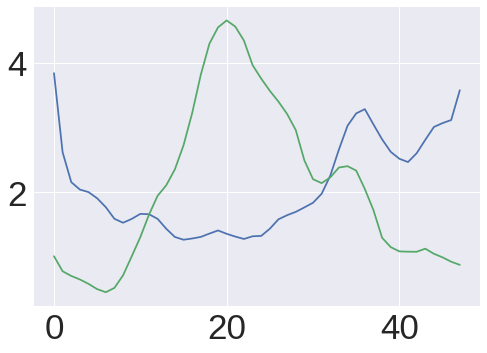

In [444]:
plt.plot(pca.mean_ + pca.components_[0] * neg)
plt.plot(pca.mean_ + pca.components_[0] * pos)

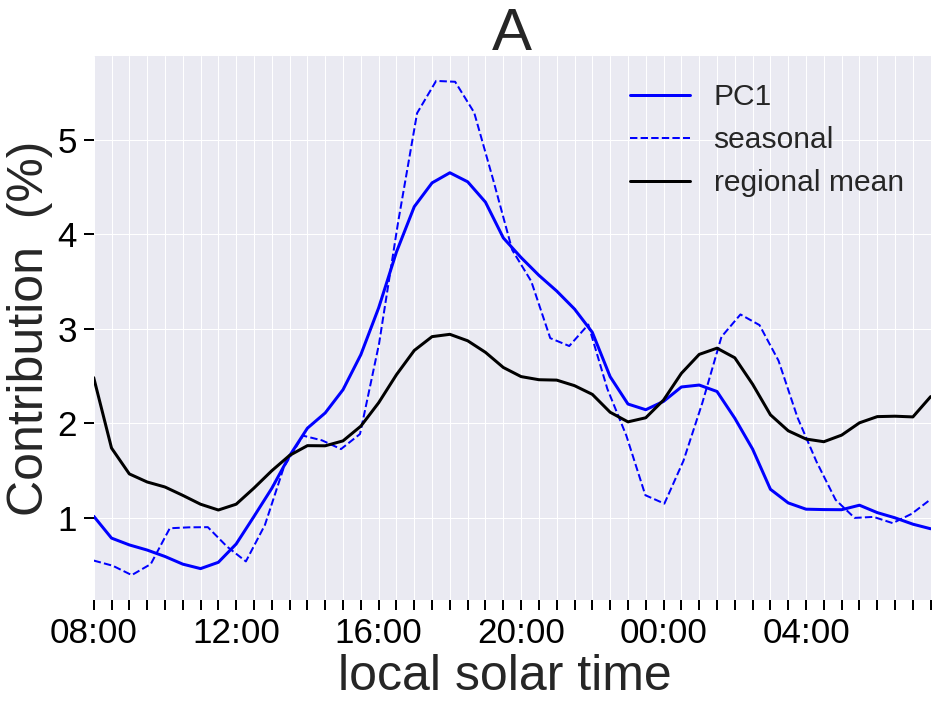

In [244]:
# reconstructed mean curves 
## mean curve 
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 35,
                     'xtick.labelsize' : 35,
                     'ytick.labelsize' : 35})
plt.figure(figsize=(15, 10))



mean = pca.mean_ + pca.components_[0] * pos
localtime=np.array(())
localtime=np.append(localtime, mean[16:24])
localtime=np.append(localtime, mean[0:16])
plt.ylabel('Contribution  (%)', fontsize = 50)
plt.xlabel('local solar time ', fontsize = 50)
plt.plot(x1, mean, color= 'b',  linewidth = 3.0, label = 'PC1')
plt.plot(x2, smooth, color= 'b', linewidth= 2.0, label= 'seasonal', linestyle= '--')
plt.plot(x1, pca.mean_, color= 'k', linewidth= 3.0, label = 'regional mean')

plt.xlim(0,1)
plt.xticks(x1, ['08:00','', '','', '', '', '','', '12:00','', '','', '','', '','', '16:00','', '','', '','', '','', '20:00','', '','', '','', '','', '00:00','', '','', '','', '','', '04:00','', '','', '', ''])
plt.tick_params(direction='out', length=10, width=2, colors='k')
plt.title('A', fontsize= 60)

plt.legend( prop={'size': 30})
plt.savefig('/media/juli/Elements/comparison/pca1_diurnal_pos.png')

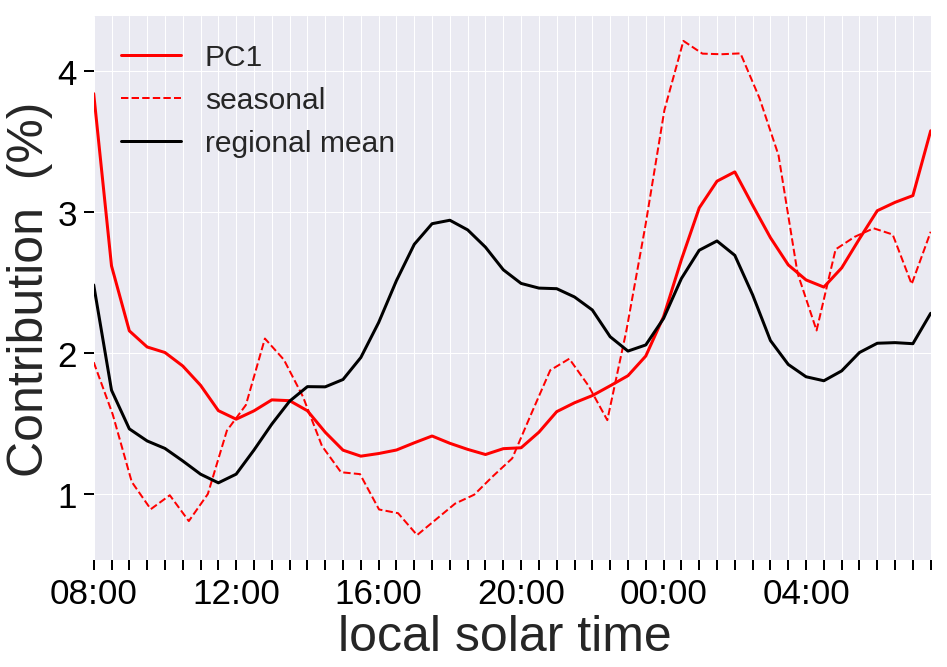

In [247]:
# reconstructed mean curves 

## mean curve 
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 35,
                     'xtick.labelsize' : 35,
                     'ytick.labelsize' : 35})
plt.figure(figsize=(15, 10))

mean = pca.mean_ + pca.components_[0] * neg
localtime=np.array(())
localtime=np.append(localtime, mean[16:24])
localtime=np.append(localtime, mean[0:16])
plt.ylabel('Contribution  (%)', fontsize = 50)
plt.xlabel('local solar time ', fontsize = 50)
plt.plot(x1, mean, color= 'r', linewidth = 3.0, label= 'PC1')
plt.plot(x2, smooth, color= 'r', linewidth= 2.0, label= 'seasonal', linestyle= '--')
plt.plot(x1, pca.mean_ ,color= 'k', linewidth= 3.0, label= 'regional mean')

plt.xlim(0,1)
plt.xticks(x1, ['08:00','', '','', '', '', '','', '12:00','', '','', '','', '','', '16:00','', '','', '','', '','', '20:00','', '','', '','', '','', '00:00','', '','', '','', '','', '04:00','', '','', '', ''])
plt.tick_params(direction='out', length=10, width=2, colors='k')

plt.legend( prop={'size': 30})
plt.savefig('/media/juli/Elements/comparison/pca1_diurnal_neg.png')

In [217]:
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'


In [203]:
# GPM mask 


# extract only values above 3000 m a.s.l. 
def read_in_netcdf_dem(file):
    dataset = Dataset(file)    
    dem= np.array(dataset["Band1"])
    lon= np.array(dataset["lon"])
    lat= np.array(dataset["lat"])
    dataset.close()
    return dem, lon, lat


import xarray as xr
import xesmf as xe
# open netCDF file with xarray
ds = '/media/juli/Data/master_thesis/Master_thesis/data/DEM_TP.tif/dem_small.nc'
dem= xr.open_dataset(ds)
elevations = dem['Band1'].values
lat= dem['lat'].values
lon= dem['lon'].values



# DEM for GPM (0.1 x 0.1 )
# output grid for resizing
lo= np.arange(70.05,105.05,0.1)
la= np.arange(26.95,44.95,0.1)
ds_out = xr.Dataset({'lat': (['lat'], la),'lon': (['lon'], lo),})

# resize elevation to 0.1 x 0.1 grid 
regridder = xe.Regridder(dem, ds_out, 'bilinear', reuse_weights=True)
dem_new = regridder(elevations) # regridder has been saved to current directory 
dem_new= np.hstack((dem_new,np.zeros((dem_new.shape[0],1))))
dem_new= dem_new.T


Reuse existing file: bilinear_4800x8400_181x350.nc


In [204]:
# GPM
gpm_mask= dem_new <  3000


In [214]:
pca1_TP= pca1[gpm_mask == True]

/home/juli/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


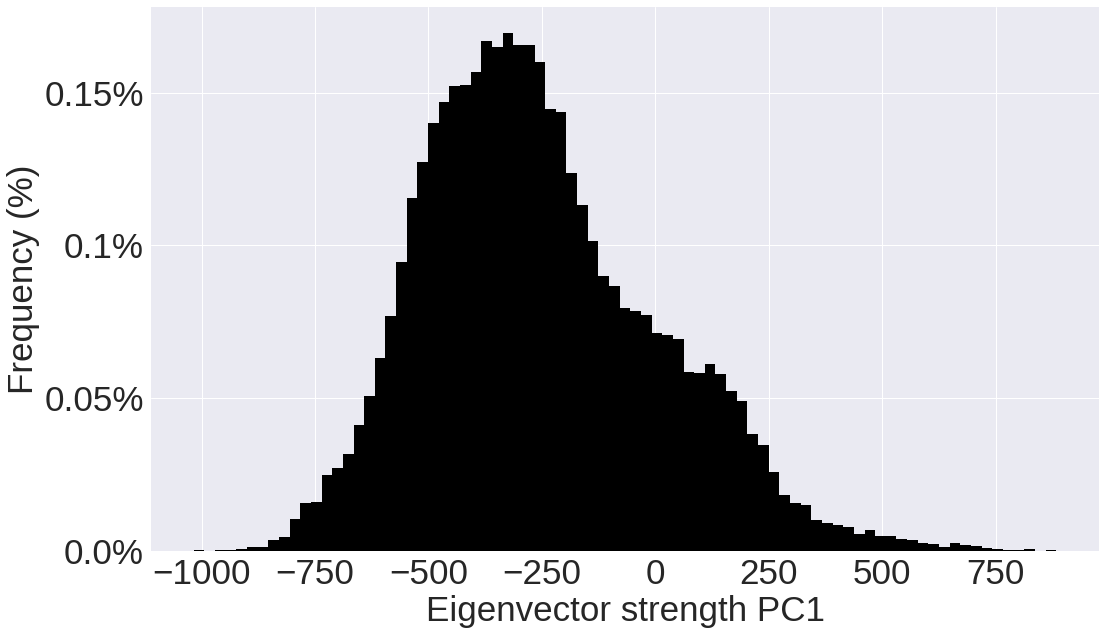

In [218]:
# Histogram of PCA1 diurnal normalized 
import matplotlib
from matplotlib.ticker import FuncFormatter


## mean curve 
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 35,
                     'xtick.labelsize' : 35,
                     'ytick.labelsize' : 35})
plt.figure(figsize=(17, 10))

plt.hist(pca1_TP.flatten(), bins= 81, color= 'k', normed = True)


# Create the formatter using the function to_percent. This multiplies all the
# default labels by 100, making them all percentages
formatter = FuncFormatter(to_percent)

# Set the formatter
plt.gca().yaxis.set_major_formatter(formatter)


plt.ylabel('Frequency (%)', fontsize= 35)
plt.xlabel('Eigenvector strength PC1', fontsize = 35)
plt.savefig('/media/juli/Elements/comparison/pca1_hist_TP.png')


/home/juli/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


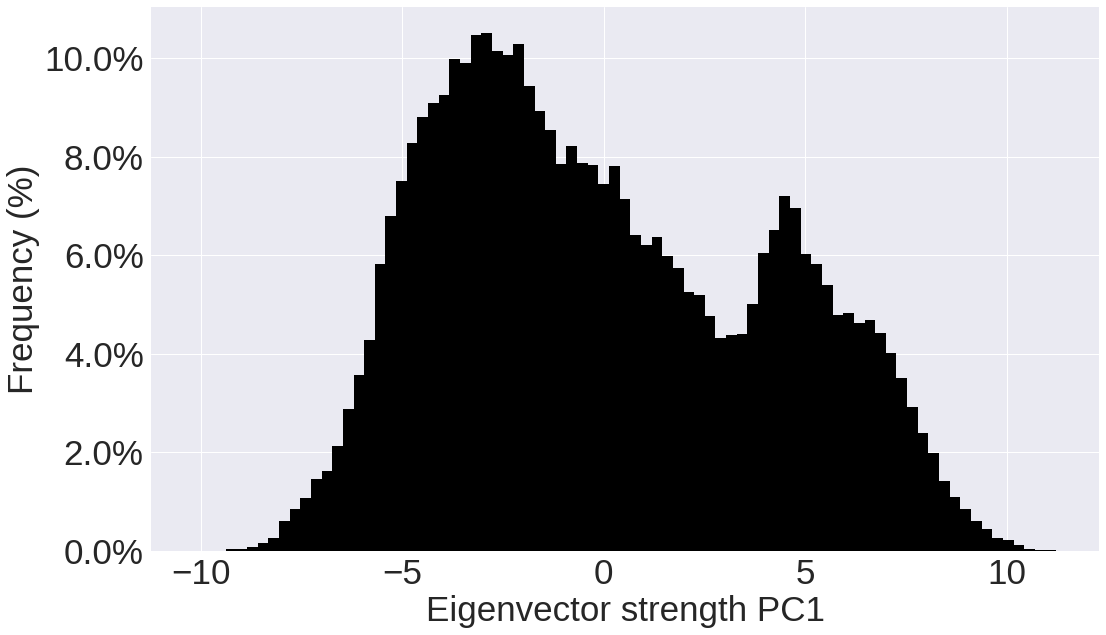

In [513]:
# Histogram of PCA1 diurnal normalized 
import matplotlib
from matplotlib.ticker import FuncFormatter


## mean curve 
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 35,
                     'xtick.labelsize' : 35,
                     'ytick.labelsize' : 35})
plt.figure(figsize=(17, 10))

plt.hist(pca1.flatten(), bins= 81, color= 'k', normed = True)


# Create the formatter using the function to_percent. This multiplies all the
# default labels by 100, making them all percentages
formatter = FuncFormatter(to_percent)

# Set the formatter
plt.gca().yaxis.set_major_formatter(formatter)


plt.ylabel('Frequency (%)', fontsize= 35)
plt.xlabel('Eigenvector strength PC1', fontsize = 35)
plt.savefig('/media/juli/Elements/comparison/pca1_hist.png')


# maybe clusters! bimodal distr.

In [396]:
# explained variance of PCs

var

array([0.52826726, 0.21775094], dtype=float32)

In [41]:
# attributes of instance 
comps= pca.components_ # direction of max variance, sorted by explained variance, shape = n components x n features 
var= pca.explained_variance_ratio_ # how much of the variance (%)is explained by each component (shape = n components)
pca.singular_values_ # shape = n_components 
means = pca.mean_ # shape = n_features 


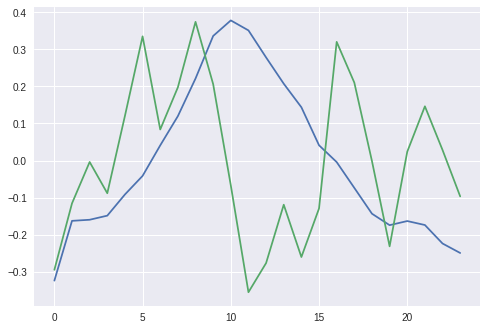

In [231]:
# plot components 

comp1=np.array(())
comp1=np.append(comp1, comps[0, 32:48])
comp1=np.append(comp1, comps[0, 0:32])


comp2=np.array(())
comp2=np.append(comp2, comps[1, 32:48])
comp2=np.append(comp2, comps[1, 0:32])


plt.plot(comp1)
plt.plot(comp2)



#plt.plot(comp1+localtime)
#plt.plot(comp2+localtime)
plt.show()

In [19]:
#import eofs # another package, library for meteorological data

- solve package inconsistencies